In [59]:
import pandas as pd

import ast
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import bootstrap

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", None)


DEFAULT_FONT_SIZE = 16
mpl.rcParams.update({
    "font.size": DEFAULT_FONT_SIZE,         
    "axes.titlesize": DEFAULT_FONT_SIZE,
    "axes.labelsize": DEFAULT_FONT_SIZE,
    "legend.fontsize": DEFAULT_FONT_SIZE,
    "xtick.labelsize": DEFAULT_FONT_SIZE,
    "ytick.labelsize": DEFAULT_FONT_SIZE,
    "font.family":'monospace'
})

output_folder = "analysis/figures"
full_df = pd.read_csv("results/all_runs_latest.csv")





## Formatting and plotting functions

In [60]:
def format_data(in_df):
    df = in_df.copy()
    df = df[(df['Run ID'].str.startswith('2026012'))]

    config_map = {
        "ctx1_fog00_p4pfalse_contract_contract_for_finishing_selfish11": "Finishing Contract",
        "ctx1_fog00_p4pfalse_contract_none_selfish11": "No Contract",
        "ctx1_fog00_p4pfalse_contract_strict_selfish11": "Strict Contract",
        "ctx1_fog00_p4pfalse_contract_tile_with_judge_implementation_selfish11": "Judge Contract",
        "ctx1_fog00_p4ptrue_contract_contract_for_finishing_selfish11": "P4P Finishing Contract",
        "ctx1_fog00_p4ptrue_contract_none_selfish11": "P4P No Contract",
        "ctx1_fog00_p4ptrue_contract_strict_selfish11": "P4P Strict Contract",
        "ctx1_fog00_p4ptrue_contract_tile_with_judge_implementation_selfish11": "P4P Judge Contract"
    }
    df['Config Label'] = df['Config ID'].map(config_map)
    df['Contract Type'] = df['Contract Type'].fillna('No Contract')
    df["Contract Type"] = df["Contract Type"].replace({
        "tile_with_judge_implementation": "NL-Trading",
        "strict": "Prog-Trading",
        "contract_for_finishing": "Prog-Points"
        })
    models = df["Model Pair"].str.partition("-")
    same_model = models[0] == models[2]
    df["Model"] = np.where(same_model, models[0], df["Model Pair"])
    df["Bucket"] = df["Bucket"].replace({
        "Independent (Both have optimal paths)": "Independent",
        "Needy Player (Blue)": "Asymmetric"
    })
    
    # check if 0 or 1 have final leverage tile in the gir
    def _has_final_leverage_tile(grid_str: str, target: str) -> bool:
        g = ast.literal_eval(grid_str)  # safer than eval
        return (g[2][3] == target) and (g[3][2] == target)
    df["P-Red Has Final Leverage Tile"] = df["Grid"].apply(lambda s: _has_final_leverage_tile(s, "R"))
    df["P-Blue Has Final Leverage Tile"] = df["Grid"].apply(lambda s: _has_final_leverage_tile(s, "B"))
    df["Either Player Has Final Leverage Tile"] = df["P-Red Has Final Leverage Tile"] | df["P-Blue Has Final Leverage Tile"]

    # core metrics: both finished and accuracy
    df['Both Finished'] = (df['Reached Goal P-Red'] > 0) & (df['Reached Goal P-Blue'] > 0)
    df['Normalized Joint Reward'] = df['Joint Reward'] / df['Max Possible Reward']
    # df['Reward P-Red'] = df['Reward P-Red']
    # df['Reward P-Blue'] = df['Reward P-Blue']

    
    # beating baselines is core metric for NPB analysis
    # For independent it is not possbile for both to beat baseline
    # For mutual dependency , it is equivalent to both finishing
    df['R_beats_baseline'] = df['Reward P-Red'] > df['Non-Cooperative Baseline P-Red']
    df['B_beats_baseline'] = df['Reward P-Blue'] > df['Non-Cooperative Baseline P-Blue']
    df['Both Beat Baseline'] = df['R_beats_baseline'] & df['B_beats_baseline']
    df['All Beat Baseline'] = df['Both Beat Baseline']
    df['Both Beat Zero Cooperation Baseline'] = df['Both Beat Baseline']
    
    ## equality measures
    ## use this to look at first mover advantage for contracts, as well as if P0 can leverage its better situation in NPB
    # points_proportion_P-Red another core metric (i prefer it to gini b/c easier to interpret)
    df["Proportion of Total Points for P-Red"] = df['Reward P-Red'] / (df['Reward P-Red'] + df['Reward P-Blue'])
    df['trade_volume_proportion_P-Red'] = df['amount_received_by_P-Red_from_trades'] / (df['amount_received_by_P-Red_from_trades'] + df['amount_received_by_P-Blue_from_trades'])
    # note that P-Blue keeping a p4p promise is equivalent to P-Red receiving a p4p payment
    df['p4p_volume_proportion_P-Red'] = df['Total P4P Promises Kept P-Blue'] / (df['Total P4P Promises Kept P-Blue'] + df['Total P4P Promises Kept P-Red'])
    df['strict_contract_tile_proportion_P-Red'] = df['num_tiles_promised_to_receive_from_contract_P-Red'] / (df['num_tiles_promised_to_receive_from_contract_P-Red'] + df['num_tiles_promised_to_receive_from_contract_P-Blue'])
    df['contract_for_finishing_points_proportion_P-Red'] = df['points_for_completion_promised_to_P-Red'] / (df['points_for_completion_promised_to_P-Red'] + df['points_for_completion_promised_to_P-Blue'])
    
    df[[

        'trade_volume_proportion_P-Red',
        'p4p_volume_proportion_P-Red',
        'strict_contract_tile_proportion_P-Red',
        'contract_for_finishing_points_proportion_P-Red']] = df[[
                                                             'trade_volume_proportion_P-Red',
                                                             'p4p_volume_proportion_P-Red',
                                                             'strict_contract_tile_proportion_P-Red',
                                                             'contract_for_finishing_points_proportion_P-Red']].fillna(0.5)  # if no data, assume equal split
 
    ## cooperation metrics
    df['total_trade_volume'] = df['amount_received_by_P-Red_from_trades'] + df['amount_received_by_P-Blue_from_trades']
    df['trade_acceptance_rate_P-Red'] = df['Total Trades Accepted P-Red'] / df['Total Trades Proposed P-Blue']
    df['trade_acceptance_rate_P-Blue'] = df['Total Trades Accepted P-Blue'] / df['Total Trades Proposed P-Red']
    df['total_trade_acceptance_rate'] = (df['Total Trades Accepted P-Red'] + df['Total Trades Accepted P-Blue']) / (df['Total Trades Proposed P-Red'] + df['Total Trades Proposed P-Blue'])
    df['moves_made_under_strict_contract_total'] = df['moves_made_under_strict_contract_P-Red'] + df['moves_made_under_strict_contract_P-Blue']
    df['Total Trades Proposed'] = df['Total Trades Proposed P-Red'] + df['Total Trades Proposed P-Blue']

    df['parity_trade_acceptance_rate'] = (df['parity_trades_accepted_P-Red'] + df['parity_trades_accepted_P-Blue']) / (df['parity_trades_offered_P-Red'] + df['parity_trades_offered_P-Blue'])
    
    # if 0 accepts a concessionary trade, that means 1 proposed a extractive trade etc
    df['extractive_trades_acceptance_rate'] = (df['concessionary_trades_accepted_P-Red'] + df['concessionary_trades_accepted_P-Blue']) / (df['extractive_trades_offered_P-Red'] + df['extractive_trades_offered_P-Blue'])
    df['concessionary_trades_acceptance_rate'] = (df['extractive_trades_accepted_P-Red'] + df['extractive_trades_accepted_P-Blue']) / (df['concessionary_trades_offered_P-Red'] + df['concessionary_trades_offered_P-Blue'])

    # make bad trade flag
    any_parity = (df["parity_trades_offered_P-Red"] > 0) | (df["parity_trades_offered_P-Blue"] > 0)
    any_conc_offered = (df["concessionary_trades_offered_P-Red"] > 0) | (df["concessionary_trades_offered_P-Blue"] > 0)
    any_extractive_accepted = (df["extractive_trades_accepted_P-Red"] > 0) | (df["extractive_trades_accepted_P-Blue"] > 0)


    # parity / concessionary trade by *red* (P-Red)
    red_parity = df["parity_trades_offered_P-Red"] > 0
    red_conc   = df["concessionary_trades_offered_P-Red"] > 0
    red_parity_accepted = df["parity_trades_accepted_P-Red"] > 0
    red_conc_accepted   = df["concessionary_trades_accepted_P-Red"] > 0

    cond_independent = df["Bucket"] == "Independent"
    cond_md = df["Bucket"] == "Mutual Dependency"
    cond_asymmetric  = df["Bucket"] == "Asymmetric"

    df["Bad Trade"] = False
    df.loc[cond_independent & (any_parity | any_conc_offered | any_extractive_accepted), "Bad Trade"] = True
    df.loc[cond_md & (any_conc_offered | any_extractive_accepted), "Bad Trade"] = True
    df.loc[cond_asymmetric  & (red_parity | red_conc | red_parity_accepted | red_conc_accepted), "Bad Trade"] = True


    # P4P promise honour rates
    df['P4P Promise Honour Rate P-Red'] = df['Total P4P Promises Kept P-Red'] / (df['Total P4P Promises Kept P-Red'] + df['Total P4P Promises Broken P-Red'])
    df['P4P Promise Honour Rate P-Blue'] = df['Total P4P Promises Kept P-Blue'] / (df['Total P4P Promises Kept P-Blue'] + df['Total P4P Promises Broken P-Blue'])
    df['Total P4P Promise Honour Rate'] = (df['Total P4P Promises Kept'] ) / (df['Total P4P Promises Kept'] + df['Total P4P Promises Broken'])

    for model_pair in df['Model Pair'].unique():
        print(f"Model Pair {model_pair} has {len(df[df['Model Pair'] == model_pair])} rows.")

    print(f"Formatted data with {len(df['Model Pair'].unique())} unique model pairs,  {len(df)} total rows")
    return df

In [61]:
df = format_data(full_df)

Model Pair LLAMA_MAVERICK-LLAMA_MAVERICK has 640 rows.
Model Pair QWEN_3_235B-QWEN_3_235B has 640 rows.
Model Pair QWEN_3_30B-QWEN_3_30B has 640 rows.
Model Pair LLAMA_SCOUT-LLAMA_SCOUT has 640 rows.
Model Pair FOUR_1-FOUR_1 has 640 rows.
Model Pair HAIKU_4_5-HAIKU_4_5 has 640 rows.
Formatted data with 6 unique model pairs,  3840 total rows


In [65]:
df['Format Errors P-Red'].value_counts() 

Format Errors P-Red
0    3651
1     158
2      20
4       8
3       2
5       1
Name: count, dtype: int64

In [66]:
df['Format Errors P-Blue'].value_counts()

Format Errors P-Blue
0    3464
1     266
2      66
3      23
4      13
7       3
5       3
6       2
Name: count, dtype: int64

In [68]:
df['Format Errors Judge'].value_counts()

Format Errors Judge
0    3822
1      18
Name: count, dtype: int64

In [8]:
def format_comparison_data(df):
    
    df_baseline = df[(df['Contract Type'] == 'No Contract') & (df['Pay4Partner'] == False)].copy()
    df_modifictations = df[(df['Contract Type'] != 'No Contract') | (df['Pay4Partner'] == True)].copy()
    df_compared_to_baseline = df_modifictations.merge(df_baseline, 
        on=['Model Pair', 'Grid ID'],
        suffixes=('', ' Baseline')
    )

    # df_compared_to_baseline['Normalized Joint Reward Change'] = df_compared_to_baseline['Normalized Joint Reward']-df_compared_to_baseline['Normalized Joint Reward Baseline']
    
    # df_compared_to_baseline['Proportion of Total Points for Red Player Change'] = df_compared_to_baseline['Proportion of Total Points for Red Player'] - df_compared_to_baseline['Proportion of Total Points for Red Player Baseline']

    # df_compared_to_baseline['Both Players Beat Baseline Change'] = df_compared_to_baseline['Both Players Beat Baseline'] - df_compared_to_baseline['all Players Beat Baseline Baseline'].astype(int)

    return df_compared_to_baseline

In [9]:

def plot_mean_metric_bar(
    df: pd.DataFrame,
    metric: str,
    x: str,
    hue: str | None = None,
    filters: list[tuple[str, list]] | None = None,
    display_filter: bool = True,
    order: list | None = None,
    hue_order: list | None = None,
    figsize=(12, 6),
    title: str | None = None,
    rotate_xticks=10,
    ylim=(0, 1),
    palette="Set2",
):
    data = df.copy()

    filter_text = ""
    if filters:
        filter_text = ';\n '.join([f"{col} in {allowed}" for col, allowed in filters])
        for col, allowed in filters:
            if col not in data.columns:
                raise ValueError(f"Filter column '{col}' not in df.columns")
            data = data[data[col].isin(allowed)]

    required = [x, metric] + ([hue] if hue else [])
    missing = [c for c in required if c not in data.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    data = data.dropna(subset=required)
    if data.empty:
        raise ValueError("No data left after filtering/dropna.")

    group_cols = [x] + ([hue] if hue else [])
    grouped = (
        data.groupby(group_cols, observed=True)[metric]
            .agg(mean="mean", std="std", n="count")
            .reset_index()
    )
    grouped["sem"] = np.where(grouped["n"] > 1, grouped["std"] / np.sqrt(grouped["n"]), 0.0)

    x_levels = order if order is not None else list(pd.unique(grouped[x]))
    if hue:
        h_levels = hue_order if hue_order is not None else list(pd.unique(grouped[hue]))
    else:
        h_levels = [None]

    if hue:
        mean_mat = grouped.pivot(index=x, columns=hue, values="mean").reindex(index=x_levels, columns=h_levels)
        sem_mat = grouped.pivot(index=x, columns=hue, values="sem").reindex(index=x_levels, columns=h_levels)
        colors = sns.color_palette(palette, n_colors=len(h_levels))
    else:
        mean_mat = grouped.set_index(x)["mean"].reindex(x_levels).to_frame("mean")
        sem_mat = grouped.set_index(x)["sem"].reindex(x_levels).to_frame("sem")
        colors = sns.color_palette(palette, n_colors=1)

    fig, ax = plt.subplots(figsize=figsize)

    x_pos = np.arange(len(x_levels))
    if hue:
        width = 0.8 / max(len(h_levels), 1)
        offsets = (np.arange(len(h_levels)) - (len(h_levels) - 1) / 2) * width

        for j, h_val in enumerate(h_levels):
            y = mean_mat[h_val].to_numpy(dtype=float)
            yerr = sem_mat[h_val].to_numpy(dtype=float)

            ax.bar(
                x_pos + offsets[j],
                y,
                width=width,
                yerr=yerr,
                capsize=4,
                label=str(h_val),
                color=colors[j],
                alpha=0.9,
                edgecolor="black",
                linewidth=0.3,
            )
        ax.legend(title=hue, loc="best")
    else:
        y = mean_mat["mean"].to_numpy(dtype=float)
        yerr = sem_mat["sem"].to_numpy(dtype=float)

        # one color per x-level
        bar_colors = sns.color_palette(palette, n_colors=len(x_levels))

        ax.bar(
            x_pos,
            y,
            width=0.7,
            yerr=yerr,
            capsize=4,
            color=bar_colors,
            alpha=0.9,
            edgecolor="black",
            linewidth=0.3,
        )

    ax.set_xticks(x_pos)
    ax.set_xticklabels([str(v) for v in x_levels], rotation=rotate_xticks, ha="right")
    # ax.set_xlabel(x, fontsize=DEFAULT_FONT_SIZE)
    ax.set_ylabel(f"Mean {metric.replace('_',' ')}")
    ax.set_title(title if title else None)

    if ylim is not None:
        ax.set_ylim(*ylim)

    plt.savefig(f"{output_folder}/mean_{metric.replace(' ', '_').lower()}_by_{x.lower()}.pdf", format="pdf", bbox_inches="tight")
    fig.tight_layout()
    plt.show()

    return grouped

## Creating Data

In [10]:
df = format_data(full_df)
df_compared_to_baseline = format_comparison_data(df)


Model Pair LLAMA_MAVERICK-LLAMA_MAVERICK has 640 rows.
Model Pair QWEN_3_235B-QWEN_3_235B has 640 rows.
Model Pair QWEN_3_30B-QWEN_3_30B has 640 rows.
Model Pair LLAMA_SCOUT-LLAMA_SCOUT has 640 rows.
Model Pair FOUR_1-FOUR_1 has 640 rows.
Model Pair HAIKU_4_5-HAIKU_4_5 has 640 rows.
Formatted data with 6 unique model pairs,  3840 total rows


## Distinct values for Model, Bucket, Contract

In [11]:
model_order = ['FOUR_1', 'HAIKU_4_5', 'LLAMA_MAVERICK', 'LLAMA_SCOUT', 'QWEN_3_235B', 'QWEN_3_30B']
bucket_order = ["Independent", "Mutual Dependency", "Asymmetric"]
contract_order = ['No Contract', 'Prog-Points',   'NL-Trading', 'Prog-Trading']

## Master Graph

Saved figure to analysis/figures/joint_reward_gini_bothbeat_by_contract_stacked_buckets_p4p_False.pdf


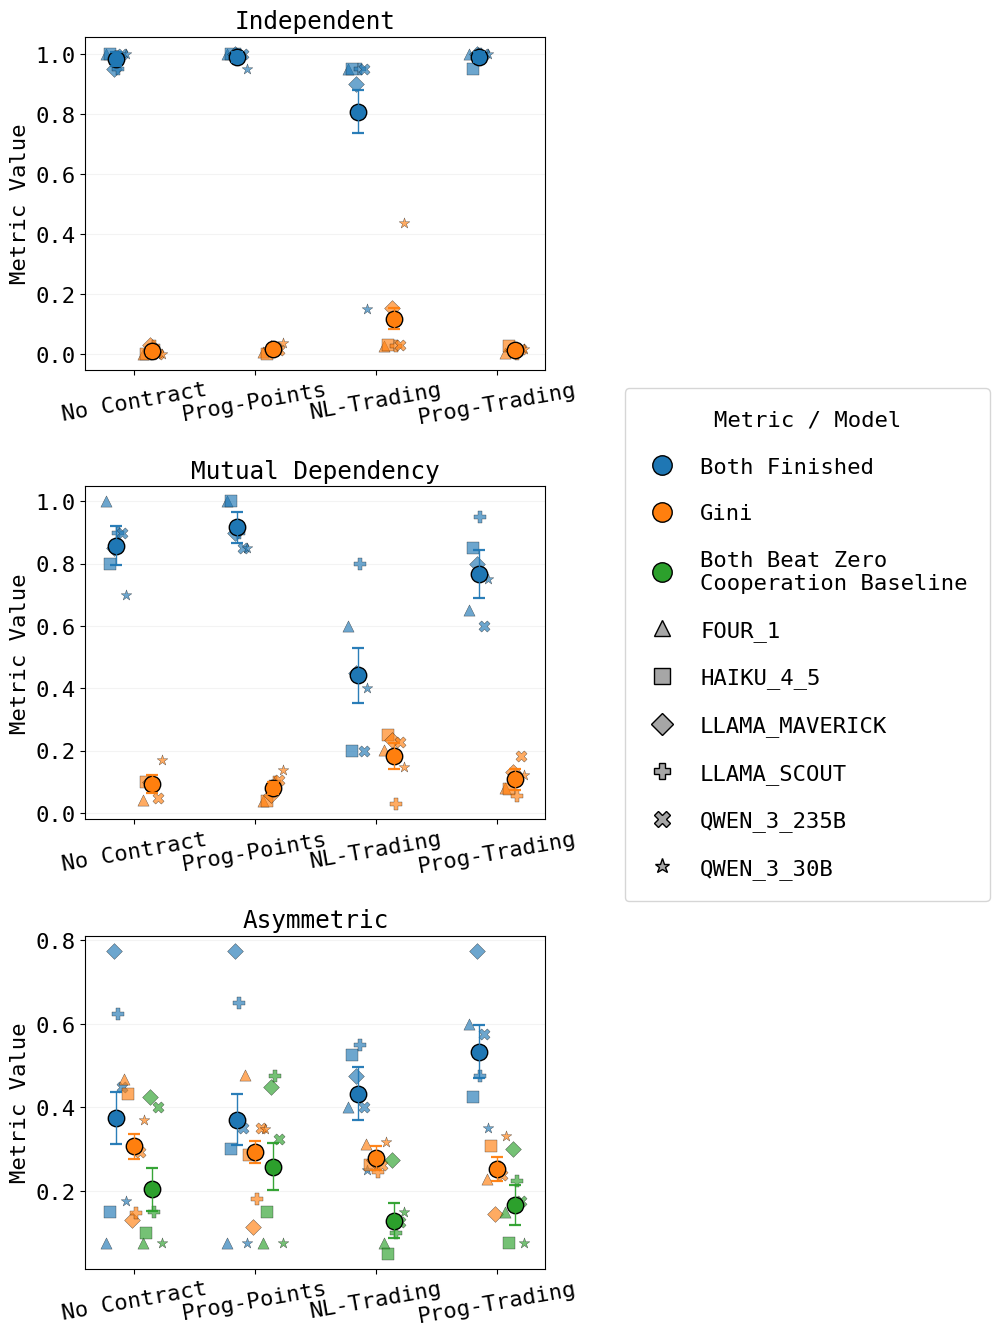

In [12]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import textwrap

def plot_joint_reward_and_gini_by_contract_stacked_buckets(
    df: pd.DataFrame,
    buckets: list[str],
    p4p: bool,
    contract_order: list[str],
    output_folder: str,
    joint_col: str = "Normalized Joint Reward",
    gini_col: str = "Gini",
    both_beat_col: str = "Both Beat Baseline",   # <-- add (name in df)
    both_beat_bucket: str = "Asymmetric",        # <-- add
    figsize=(12, 12),
    rotate_xticks=10,
):
    RT = df.copy()
    RT = RT[(RT["Bucket"].isin(buckets)) & (RT["Pay4Partner"] == p4p)].copy()
    RT["Contract Type"] = pd.Categorical(RT["Contract Type"], categories=contract_order, ordered=True)

    # If gini column doesn't exist, optionally compute from rewards (2-person gini)
    if gini_col not in RT.columns:
        if ("Reward P-Red" in RT.columns) and ("Reward P-Blue" in RT.columns):
            s = RT["Reward P-Red"] + RT["Reward P-Blue"]
            RT[gini_col] = np.where(s > 0, np.abs(RT["Reward P-Red"] - RT["Reward P-Blue"]) / s, 0.0)
        else:
            raise ValueError(f"Missing '{gini_col}' and cannot compute it (need Reward P-Red/Reward P-Blue).")

    # Global color map (consistent across subplots)
    metric_to_color = {
        joint_col: "tab:blue",
        gini_col: "tab:orange",
        both_beat_col: "tab:green",
    }

    # Models -> marker shapes (shared across all subplots)
    # (use RT not melted long, since we'll melt per-bucket)
    models = sorted(RT["Model"].dropna().unique().tolist())
    model_markers = ['^', 's', 'D', 'P', 'X', '*', 'v', '<', '>', 'H']
    if len(models) > len(model_markers):
        raise ValueError(f"Not enough marker shapes for {len(models)} models; add more to model_markers.")
    model_to_marker = {m: model_markers[i] for i, m in enumerate(models)}

    xpos = {ct: i for i, ct in enumerate(contract_order)}

    # Create stacked plots
    fig, axes = plt.subplots(nrows=len(buckets), ncols=1, figsize=figsize, sharex=True)
    fig.subplots_adjust(right=0.7, hspace=0.35)
    if len(buckets) == 1:
        axes = [axes]

    for ax, b in zip(axes, buckets):
        data_b = RT[RT["Bucket"] == b].copy()

        # Choose metrics for this bucket
        metric_cols = [joint_col, gini_col]
        if b == both_beat_bucket:
            if both_beat_col not in data_b.columns:
                raise ValueError(f"'{both_beat_col}' not found in df for bucket={both_beat_bucket}.")
            metric_cols.append(both_beat_col)

        metric_order = metric_cols  # use column names directly as labels

        # Offsets (depend on number of metrics in this subplot)
        metric_span = 0.15
        metric_offsets = [0.0] if len(metric_order) == 1 else list(np.linspace(-metric_span, metric_span, num=len(metric_order)))
        metric_to_offset = {mname: metric_offsets[i] for i, mname in enumerate(metric_order)}

        model_span = 0.08
        model_offsets = [0.0] if len(models) == 1 else list(np.linspace(-model_span, model_span, num=len(models)))
        model_to_offset = {m: model_offsets[i] for i, m in enumerate(models)}

        # Long format (per bucket)
        long_b = data_b.melt(
            id_vars=["Bucket", "Contract Type", "Model"],
            value_vars=metric_cols,
            var_name="Metric",
            value_name="Value",
        )

        # per-model means
        model_means = (
            long_b
            .groupby(["Contract Type", "Model", "Metric"], as_index=False, observed=True)["Value"]
            .mean()
            .rename(columns={"Value": "Score"})
        )

        # overall mean + 95% CI
        avg_stats = (
            long_b
            .groupby(["Contract Type", "Metric"], observed=True)
            .agg(mean_score=("Value", "mean"), sd=("Value", "std"), n=("Value", "count"))
            .reset_index()
        )
        avg_stats["sem"] = avg_stats["sd"] / np.sqrt(avg_stats["n"])
        avg_stats["ci95"] = 1.96 * avg_stats["sem"]
        avg_stats.loc[avg_stats["n"] <= 1, "ci95"] = 0.0

        # Per-model points
        for metric_name in metric_order:
            dm = model_means[model_means["Metric"] == metric_name].copy()
            if dm.empty:
                continue

            for m in models:
                d = dm[dm["Model"] == m].copy()
                if d.empty:
                    continue

                xs = (
                    d["Contract Type"].map(xpos).to_numpy()
                    + metric_to_offset[metric_name]
                    + model_to_offset[m]
                )
                ys = d["Score"].to_numpy()

                ax.scatter(
                    xs,
                    ys,
                    s=65,
                    marker=model_to_marker[m],
                    color=metric_to_color[metric_name],
                    alpha=0.65,
                    edgecolors="k",
                    linewidths=0.3,
                    zorder=2,
                )

        # Means + CIs
        for metric_name in metric_order:
            d = avg_stats[avg_stats["Metric"] == metric_name].copy()
            if d.empty:
                continue

            xs = d["Contract Type"].map(xpos).to_numpy() + metric_to_offset[metric_name]
            ys = d["mean_score"].to_numpy()
            yerr = np.nan_to_num(d["ci95"].to_numpy(), nan=0.0)

            ax.scatter(
                xs,
                ys,
                s=140,
                marker="o",
                color=metric_to_color[metric_name],
                alpha=1.0,
                edgecolors="k",
                linewidths=1.0,
                zorder=6,
            )
            ax.errorbar(
                xs,
                ys,
                yerr=yerr,
                fmt="none",
                ecolor=metric_to_color[metric_name],
                elinewidth=1.0,
                capsize=4,
                capthick=1.6,
                alpha=0.95,
                zorder=10,
            )

        ax.set_title(b, loc="center", fontsize=1.1 * DEFAULT_FONT_SIZE)
        ax.set_ylabel("Metric Value", fontsize=DEFAULT_FONT_SIZE)
        ax.grid(axis="y", alpha=0.15)

        ax.set_xticks(range(len(contract_order)))
        ax.set_xticklabels(contract_order, rotation=rotate_xticks, ha="center")
        ax.tick_params(axis="x", labelbottom=True)

    # ---- Single legend for entire figure ----
    # Metrics shown in legend: always include joint+gini; include Both Beat Baseline only if Asymmetric is plotted.
    def _wrap_legend_label(s: str, width: int = 18) -> str:
        # wrap on spaces; keeps existing line breaks if already present
        return "\n".join(
            textwrap.wrap(
                str(s),
                width=width,
                break_long_words=False,
                break_on_hyphens=False,
            )
        )

    legend_metric_order = [joint_col, gini_col] + ([both_beat_col] if both_beat_bucket in buckets else [])
    legend_wrap_width = 22

    legend_handles = []
    legend_handles += [
        Line2D(
            [0], [0],
            marker="o",
            linestyle="None",
            markerfacecolor=metric_to_color[mname],
            markeredgecolor="k",
            markersize=10,
            label=_wrap_legend_label(mname, width=legend_wrap_width),
        )
        for mname in legend_metric_order
    ]
    legend_handles += [
        Line2D(
            [0], [0],
            marker=model_to_marker[m],
            linestyle="None",
            markerfacecolor="0.65",
            markeredgecolor="k",
            markersize=8,
            label=_wrap_legend_label(m, width=legend_wrap_width),
        )
        for m in models
    ]

    # Put legend IN the reserved right margin (inside the figure), so it doesn't trigger "tight" expansion.
    fig.legend(
        handles=legend_handles,
        title="Metric / Model",
        bbox_to_anchor=(0.785, 0.5),  # <-- inside figure; just to the right of axes (right=0.78)
        loc="center left",
        fontsize=DEFAULT_FONT_SIZE,
        title_fontsize=DEFAULT_FONT_SIZE,
        labelspacing=1.2,
        handletextpad=1.0,
        borderpad=1.0,
        handlelength=1.4,
        markerscale=1.4,
        frameon=True,
    )

    output_path = f"{output_folder}/joint_reward_gini_bothbeat_by_contract_stacked_buckets_p4p_{p4p}.pdf"
    fig.savefig(output_path, format="pdf")  # <-- remove bbox_inches="tight"
    print(f"Saved figure to {output_path}")
    plt.show()


# Example call:
plot_joint_reward_and_gini_by_contract_stacked_buckets(
    df=df,
    buckets=["Independent", "Mutual Dependency", "Asymmetric"],
    p4p=False,
    contract_order=contract_order,
    output_folder=output_folder,
    joint_col="Both Finished",
    gini_col="Gini",
    both_beat_col="Both Beat Zero Cooperation Baseline",
    both_beat_bucket="Asymmetric",
    figsize=(8, 16),
)

 

### Second option for master graph

Saved figure to analysis/figures/joint_and_gini_two_panels_buckets_overlaid_p4p_False.pdf


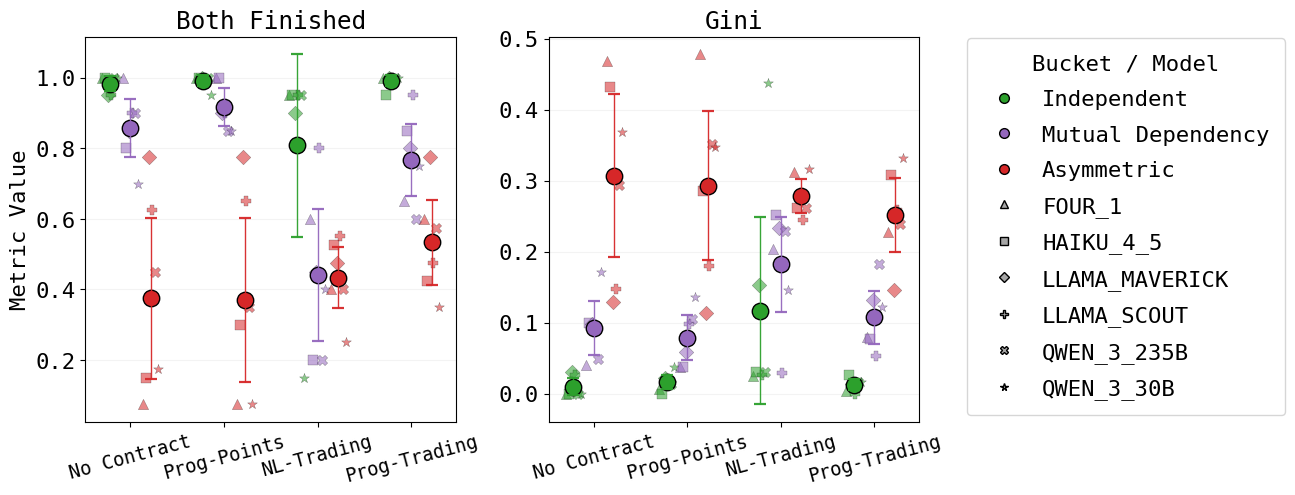

In [30]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_joint_and_gini_two_panels_buckets_overlaid(
    df: pd.DataFrame,
    buckets: list[str],
    p4p: bool,
    contract_order: list[str],
    output_folder: str,
    joint_col: str = "Both Finished",
    gini_col: str = "Gini",
    figsize=(10, 6),
    rotate_xticks=15,
):
    """
    Two subplots (Joint + Gini). Within each subplot:
      - x: Contract Type
      - y: metric value
      - bucket encoded by color
      - model encoded by marker shape
      - points = per-(Grid ID, Contract Type) mean for each model (mean across runs within that model)
      - big circles + errorbars = bucket-level mean across models (with 95% CI across model means)
    """

    RT = df.copy()
    RT = RT[(RT["Bucket"].isin(buckets)) & (RT["Pay4Partner"] == p4p)].copy()
    RT["Contract Type"] = pd.Categorical(RT["Contract Type"], categories=contract_order, ordered=True)

    # Ensure gini exists or compute it
    if gini_col not in RT.columns:
        if ("Reward P-Red" in RT.columns) and ("Reward P-Blue" in RT.columns):
            s = RT["Reward P-Red"] + RT["Reward P-Blue"]
            RT[gini_col] = np.where(s > 0, np.abs(RT["Reward P-Red"] - RT["Reward P-Blue"]) / s, 0.0)
        else:
            raise ValueError(f"Missing '{gini_col}' and cannot compute it (need Reward P-Red/Reward P-Blue).")

    # Bucket colors (consistent across both subplots)
    default_bucket_colors = {
        "Independent": "tab:green",
        "Mutual Dependency": "tab:purple",
        "Asymmetric": "tab:red",
    }
    bucket_to_color = {b: default_bucket_colors.get(b, "tab:gray") for b in buckets}

    # Model -> marker shape
    models = sorted(RT["Model"].dropna().unique().tolist())
    model_markers = ['^', 's', 'D', 'P', 'X', '*', 'v', '<', '>', 'H']
    if len(models) > len(model_markers):
        raise ValueError(f"Not enough marker shapes for {len(models)} models; add more to model_markers.")
    model_to_marker = {m: model_markers[i] for i, m in enumerate(models)}

    xpos = {ct: i for i, ct in enumerate(contract_order)}

    # Long format for two metrics only
    long = RT.melt(
        id_vars=["Bucket", "Contract Type", "Model", "Grid ID"],
        value_vars=[joint_col, gini_col],
        var_name="Metric",
        value_name="Value",
    )

    # Per-model mean at contract+bucket+metric:
    # First collapse repeats per (Grid, Contract, Model, Bucket, Metric), then average across grids.
    per_grid_model = (
        long
        .groupby(["Bucket", "Contract Type", "Model", "Metric", "Grid ID"], as_index=False, observed=True)["Value"]
        .mean()
    )

    model_means = (
        per_grid_model
        .groupby(["Bucket", "Contract Type", "Model", "Metric"], as_index=False, observed=True)["Value"]
        .mean()
        .rename(columns={"Value": "Score"})
    )

    # Bucket-level mean across model-means + 95% CI across models
    bucket_stats = (
        model_means
        .groupby(["Bucket", "Contract Type", "Metric"], observed=True)
        .agg(mean_score=("Score", "mean"), sd=("Score", "std"), n=("Score", "count"))
        .reset_index()
    )
    bucket_stats["sem"] = bucket_stats["sd"] / np.sqrt(bucket_stats["n"])
    bucket_stats["ci95"] = 1.96 * bucket_stats["sem"]
    bucket_stats.loc[bucket_stats["n"] <= 1, "ci95"] = 0.0

    # Offsets so buckets don't sit on top of each other for a given contract
    bucket_span = 0.22
    bucket_offsets = [0.0] if len(buckets) == 1 else list(np.linspace(-bucket_span, bucket_span, num=len(buckets)))
    bucket_to_offset = {b: bucket_offsets[i] for i, b in enumerate(buckets)}

    model_span = 0.08
    model_offsets = [0.0] if len(models) == 1 else list(np.linspace(-model_span, model_span, num=len(models)))
    model_to_offset = {m: model_offsets[i] for i, m in enumerate(models)}

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharex=True)
    fig.subplots_adjust(right=0.82, wspace=0.25)
    metric_to_ax = {joint_col: axes[0], gini_col: axes[1]}

    for metric, ax in metric_to_ax.items():
        # model points
        mm = model_means[model_means["Metric"] == metric]
        for b in buckets:
            mmb = mm[mm["Bucket"] == b]
            if mmb.empty:
                continue

            for m in models:
                d = mmb[mmb["Model"] == m]
                if d.empty:
                    continue

                xs = (
                    d["Contract Type"].map(xpos).to_numpy()
                    + bucket_to_offset[b]
                    + model_to_offset[m]
                )
                ys = d["Score"].to_numpy()

                ax.scatter(
                    xs,
                    ys,
                    s=55,
                    marker=model_to_marker[m],
                    color=bucket_to_color[b],
                    alpha=0.55,
                    edgecolors="k",
                    linewidths=0.25,
                    zorder=2,
                )

        # bucket means + CI
        bs = bucket_stats[bucket_stats["Metric"] == metric]
        for b in buckets:
            d = bs[bs["Bucket"] == b]
            if d.empty:
                continue

            xs = d["Contract Type"].map(xpos).to_numpy() + bucket_to_offset[b]
            ys = d["mean_score"].to_numpy()
            yerr = np.nan_to_num(d["ci95"].to_numpy(), nan=0.0)

            ax.scatter(
                xs,
                ys,
                s=140,
                marker="o",
                color=bucket_to_color[b],
                alpha=1.0,
                edgecolors="k",
                linewidths=1.0,
                zorder=6,
            )
            ax.errorbar(
                xs,
                ys,
                yerr=yerr,
                fmt="none",
                ecolor=bucket_to_color[b],
                elinewidth=1.0,
                capsize=4,
                capthick=1.6,
                alpha=0.95,
                zorder=10,
            )

        ax.set_title(metric, fontsize=1.1 * DEFAULT_FONT_SIZE)
        ax.grid(axis="y", alpha=0.15)
        ax.set_xticks(range(len(contract_order)))
        ax.set_xticklabels(contract_order, rotation=rotate_xticks, ha="center", fontsize=0.85 * DEFAULT_FONT_SIZE)

    axes[0].set_ylabel("Metric Value", fontsize=DEFAULT_FONT_SIZE)

    # One legend for whole figure: bucket colors + model shapes
    legend_handles = []
    legend_handles += [
        Line2D([0], [0], marker="o", linestyle="None",
               markerfacecolor=bucket_to_color[b], markeredgecolor="k",
               markersize=10, label=b)
        for b in buckets
    ]
    legend_handles += [
        Line2D([0], [0], marker=model_to_marker[m], linestyle="None",
               markerfacecolor="0.65", markeredgecolor="k",
               markersize=8, label=m)
        for m in models
    ]

    fig.legend(
        handles=legend_handles,
        title="Bucket / Model",
        bbox_to_anchor=(0.85, 0.5),
        loc="center left",
        fontsize=DEFAULT_FONT_SIZE,
        title_fontsize=DEFAULT_FONT_SIZE,
        labelspacing=0.7,
        handletextpad=0.7,
        borderpad=0.7,
        markerscale=0.7,
        frameon=True,
    )

    output_path = f"{output_folder}/joint_and_gini_two_panels_buckets_overlaid_p4p_{p4p}.pdf"
    fig.savefig(output_path, format="pdf")
    print(f"Saved figure to {output_path}")
    plt.show()


# Example call
plot_joint_and_gini_two_panels_buckets_overlaid(
    df=df,
    buckets=["Independent", "Mutual Dependency", "Asymmetric"],
    p4p=False,
    contract_order=contract_order,
    output_folder=output_folder,
    joint_col="Both Finished",
    gini_col="Gini",
    figsize=(12, 5),
)


## API and Format Failure

In [9]:
df.groupby("Model Pair")['Format Errors'].value_counts()

Model Pair                     Format Errors
FOUR_1-FOUR_1                  0                640
HAIKU_4_5-HAIKU_4_5            0                640
LLAMA_MAVERICK-LLAMA_MAVERICK  0                640
LLAMA_SCOUT-LLAMA_SCOUT        0                640
QWEN_3_235B-QWEN_3_235B        0                640
QWEN_3_30B-QWEN_3_30B          0                640
Name: count, dtype: int64

## Core Baseline Metric Plots

In [ ]:
core_metrics = [{'df': df,
    'metric': 'Normalized Joint Reward',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': bucket_order,
                 'hue_order': model_order,
                 'filters':[
                    ("Pay4Partner", [False]), 
                    ('Contract Type', ['No Contract'])
                ],
          
},
{'df': df,
    'metric': 'Proportion of Total Points for Red Player',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': bucket_order,
                 'hue_order': model_order,
                 'filters':[
                     ("Pay4Partner", [False]), 
                ('Contract Type', ['No Contract']),
                ],
},
{'df': df,
    'metric': 'all Players Beat Baseline',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': None,
                 'hue_order': model_order,
                 'filters':[("Pay4Partner", [False]), 
                ('Contract Type', ['No Contract']),
                ('Bucket', ['Asymmetric'])],
},


       ]

Plotting metric: Normalized Total Score


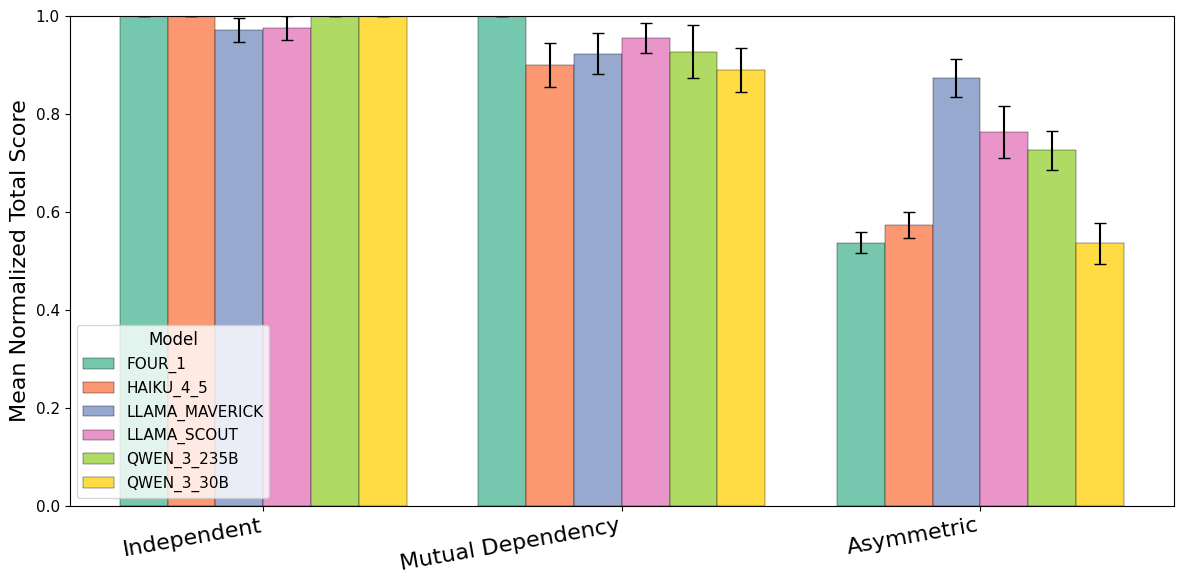

Plotting metric: Proportion of Total Points for Red Player


ValueError: Missing required columns: ['Proportion of Total Points for Red Player']

In [14]:
for metric_cfg in core_metrics:
    print(f"Plotting metric: {metric_cfg['metric']}")
    plot_mean_metric_bar(
        df=metric_cfg['df'],
        metric=metric_cfg['metric'],
        x=metric_cfg['x'],
        hue=metric_cfg.get('hue', None),
        filters=metric_cfg.get('filters', None),
        display_filter=metric_cfg.get('display_filter', True),
        order=metric_cfg.get('order', None),
        hue_order=metric_cfg.get('hue_order', None),
    )

## Strict Contracts

In [ ]:
core_metrics = [{'df': df_compared_to_baseline,
    'metric': 'Normalized Joint Reward Change',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': bucket_order,
                 'hue_order': model_order,
                 'filters':[("Pay4Partner", [False]), 
                ('Contract Type', ['strict'])],
          
},
{'df': df_compared_to_baseline,
    'metric': 'Proportion of Total Points for Red Player Change',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': bucket_order,
                 'hue_order': model_order,
                 'filters':[
                     ("Pay4Partner", [False]), 
                ('Contract Type', ['strict']),
                ],
},
{'df': df_compared_to_baseline,
    'metric': 'all Players Beat Baseline Change',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': None,
                 'hue_order': model_order,
                 'filters':[("Pay4Partner", [False]), 
                ('Contract Type', ['strict']),
                ('Bucket', ['Asymmetric'])],
},


       ]

Plotting metric: Percent of Max Score Change


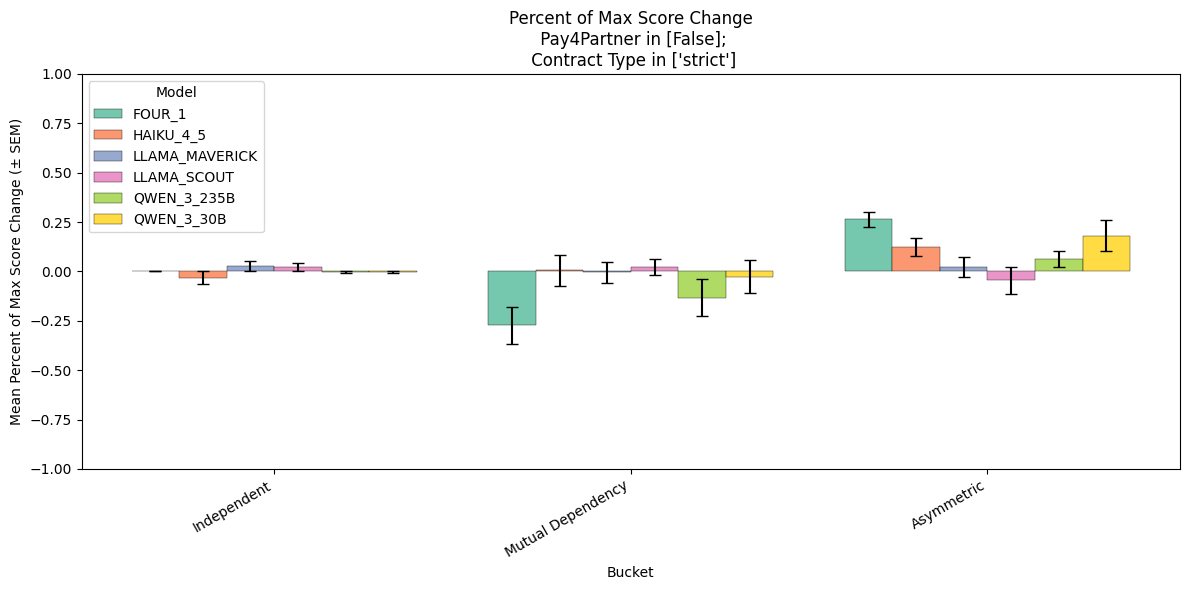

Plotting metric: Proportion of Total Points for Red Player Change


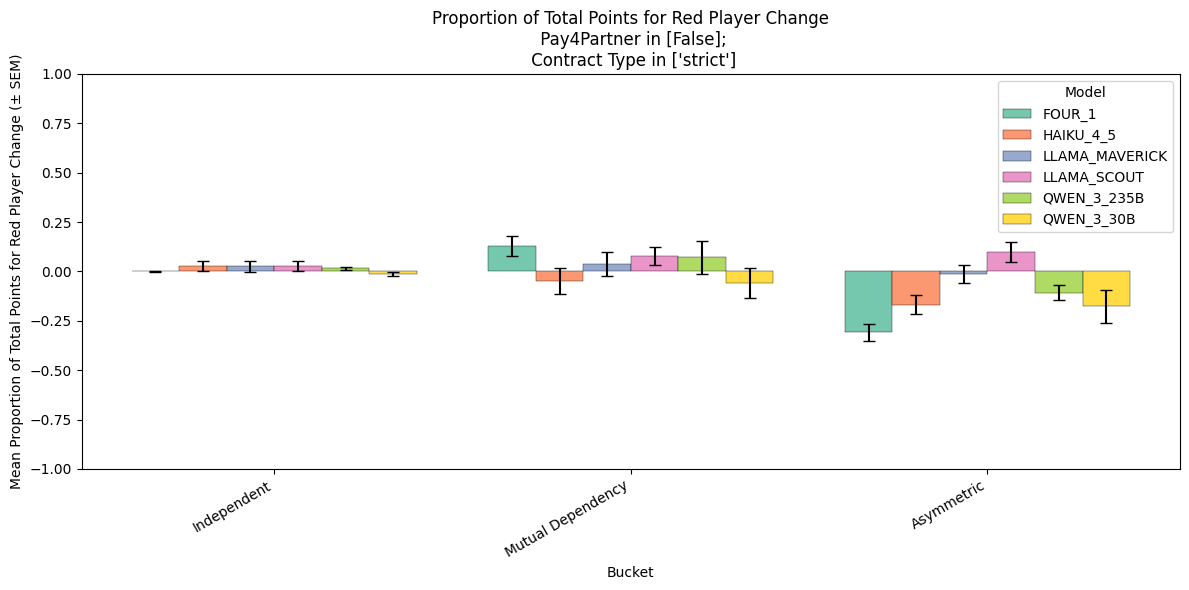

Plotting metric: Both Players Beat Baseline Change


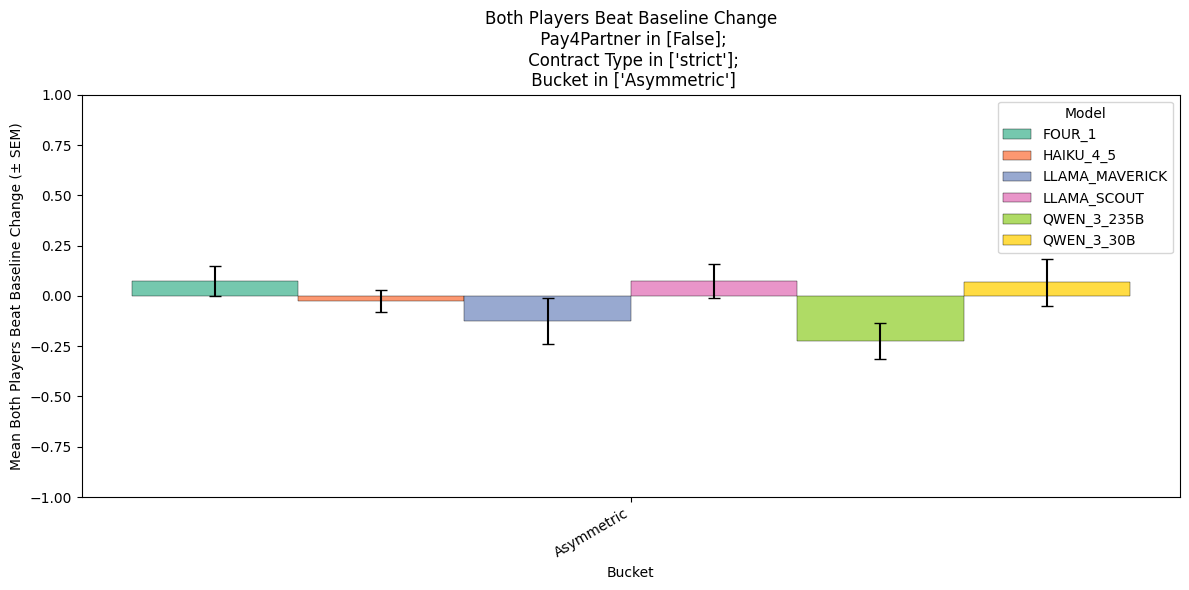

In [ ]:
for metric_cfg in core_metrics:
    print(f"Plotting metric: {metric_cfg['metric']}")
    plot_mean_metric_bar(
        df=metric_cfg['df'],
        metric=metric_cfg['metric'],
        x=metric_cfg['x'],
        hue=metric_cfg.get('hue', None),
        filters=metric_cfg.get('filters', None),
        display_filter=metric_cfg.get('display_filter', True),
        order=metric_cfg.get('order', None),
        hue_order=metric_cfg.get('hue_order', None),
        ylim=(-1, 1),
    )

## Contract For Finishing 

Plotting metric: Percent of Max Score Change


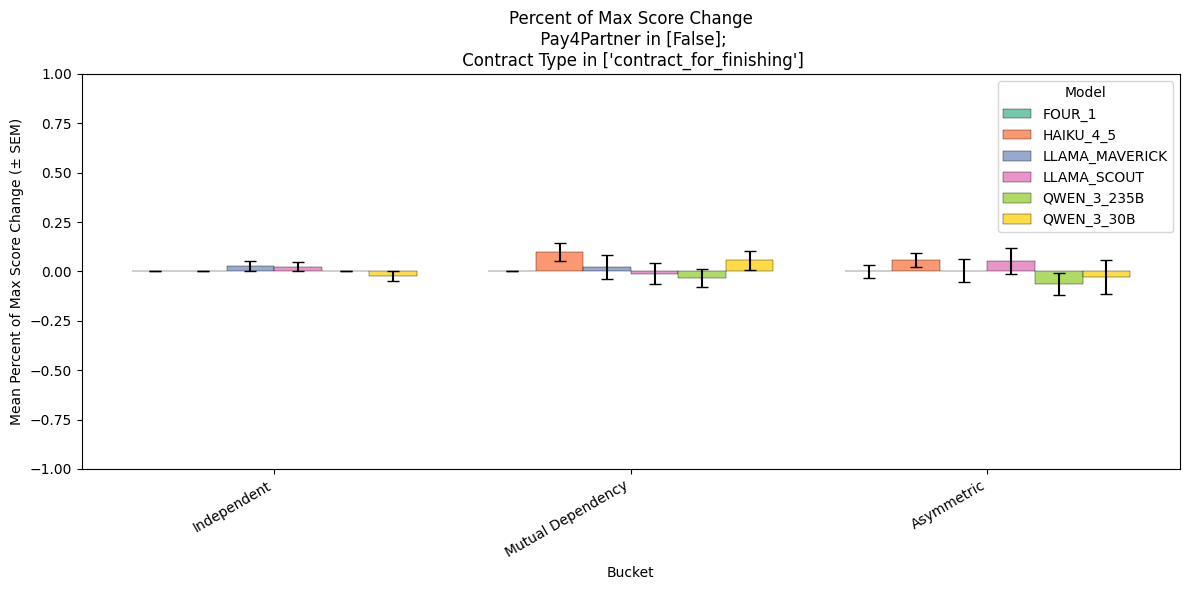

Plotting metric: Proportion of Total Points for Red Player Change


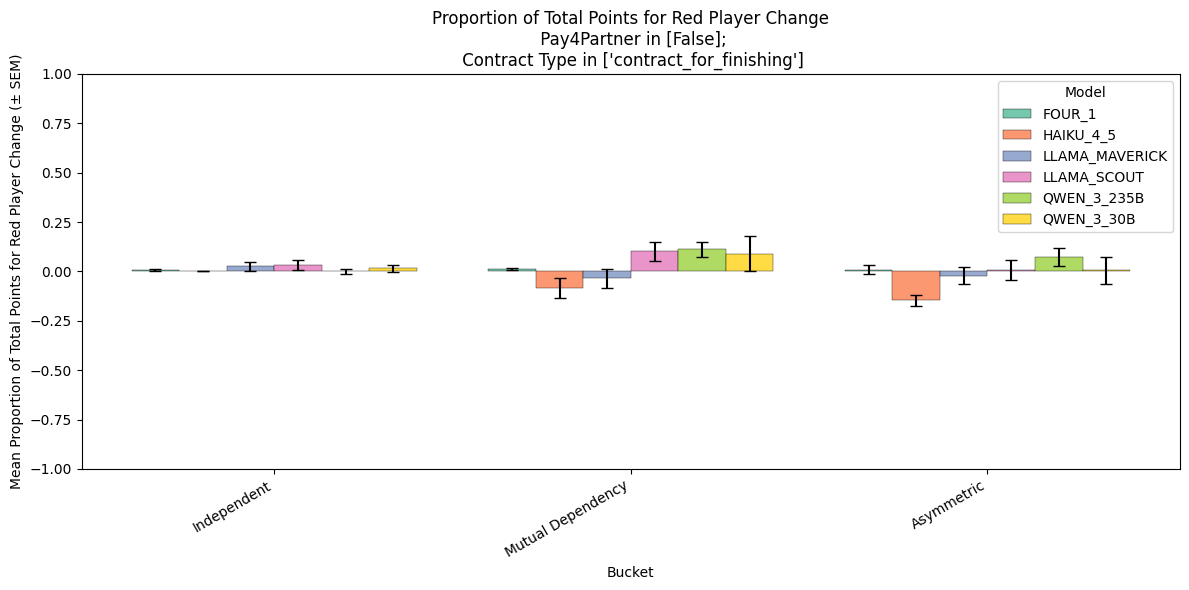

Plotting metric: Both Players Beat Baseline Change


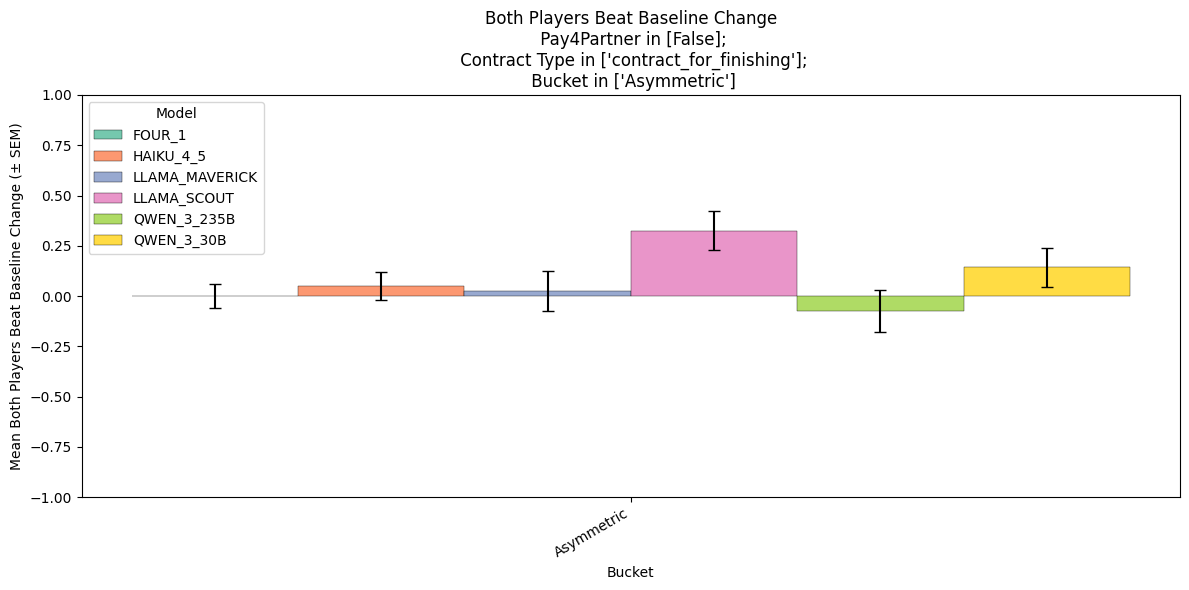

In [ ]:
core_metrics = [{'df': df_compared_to_baseline,
    'metric': 'Normalized Joint Reward Change',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': bucket_order,
                 'hue_order': model_order,
                 'filters':[("Pay4Partner", [False]), 
                ('Contract Type', ['contract_for_finishing'])],
          
},
{'df': df_compared_to_baseline,
    'metric': 'Proportion of Total Points for Red Player Change',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': bucket_order,
                 'hue_order': model_order,
                 'filters':[
                     ("Pay4Partner", [False]), 
                ('Contract Type', ['contract_for_finishing']),
                ],
},
{'df': df_compared_to_baseline,
    'metric': 'Both Players Beat Baseline Change',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': None,
                 'hue_order': model_order,
                 'filters':[("Pay4Partner", [False]), 
                ('Contract Type', ['contract_for_finishing']),
                ('Bucket', ['Asymmetric'])],
},


       ]

for metric_cfg in core_metrics:
    print(f"Plotting metric: {metric_cfg['metric']}")
    plot_mean_metric_bar(
        df=metric_cfg['df'],
        metric=metric_cfg['metric'],
        x=metric_cfg['x'],
        hue=metric_cfg.get('hue', None),
        filters=metric_cfg.get('filters', None),
        display_filter=metric_cfg.get('display_filter', True),
        order=metric_cfg.get('order', None),
        hue_order=metric_cfg.get('hue_order', None),
        ylim=(-1, 1),
    )

## LLM Judge 

Plotting metric: Percent of Max Score


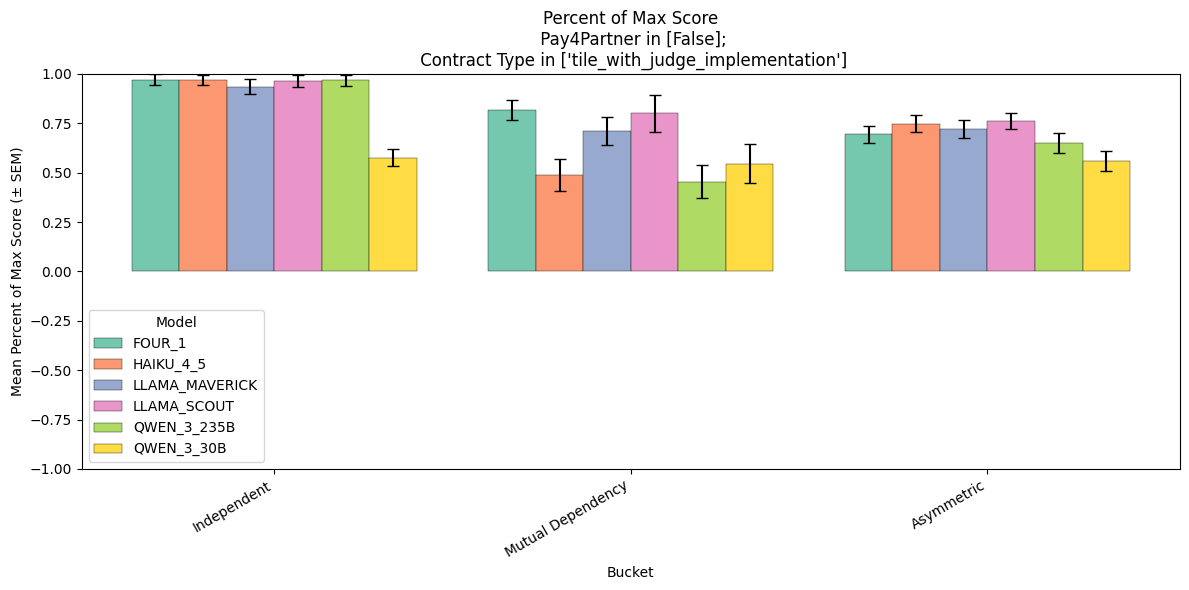

Plotting metric: Proportion of Total Points for Red Player


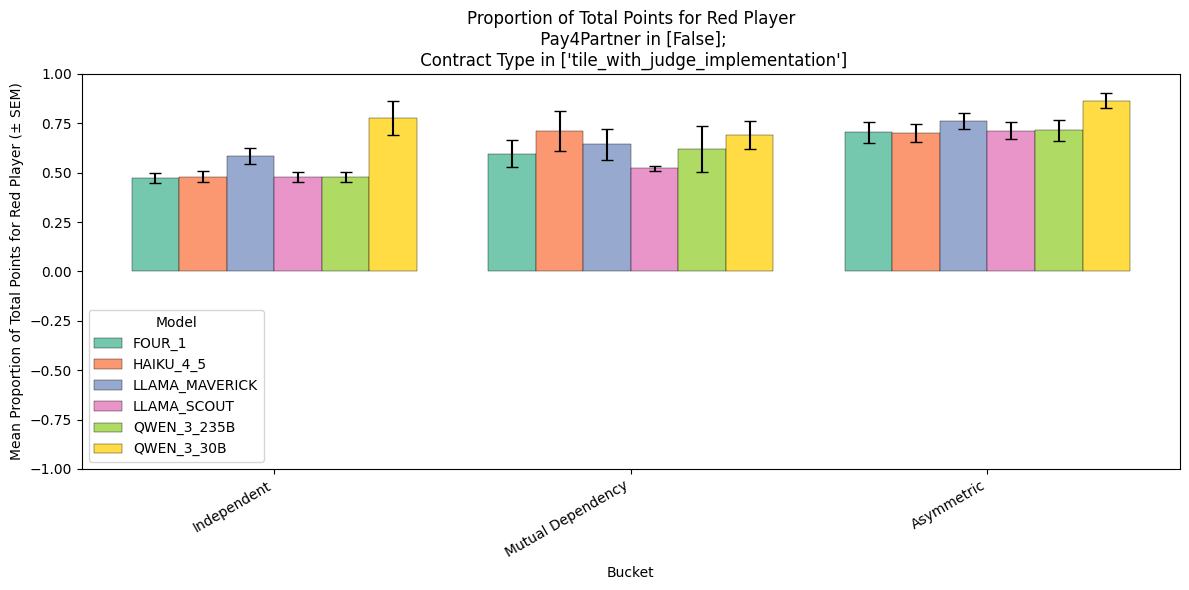

Plotting metric: Both Players Beat Baseline Change


ValueError: Missing required columns: ['Both Players Beat Baseline Change']

In [ ]:
core_metrics = [{'df': df_compared_to_baseline,
    'metric': 'Normalized Joint Reward',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': bucket_order,
                 'hue_order': model_order,
                 'filters':[("Pay4Partner", [False]), 
                ('Contract Type', ['tile_with_judge_implementation'])],
          
},
{'df': df_compared_to_baseline,
    'metric': 'Proportion of Total Points for Red Player',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': bucket_order,
                 'hue_order': model_order,
                 'filters':[
                     ("Pay4Partner", [False]), 
                ('Contract Type', ['tile_with_judge_implementation']),
                ],
},
{'df': df_compared_to_baseline,
    'metric': 'Both Players Beat Baseline Change',
                 'x': 'Bucket',
                 'hue': 'Model',
                 'order': None,
                 'hue_order': model_order,
                 'filters':[("Pay4Partner", [False]), 
                ('Contract Type', ['tile_with_judge_implementation']),
                ('Bucket', ['Asymmetric'])],
},


       ]

for metric_cfg in core_metrics:
    print(f"Plotting metric: {metric_cfg['metric']}")
    plot_mean_metric_bar(
        df=metric_cfg['df'],
        metric=metric_cfg['metric'],
        x=metric_cfg['x'],
        hue=metric_cfg.get('hue', None),
        filters=metric_cfg.get('filters', None),
        display_filter=metric_cfg.get('display_filter', True),
        order=metric_cfg.get('order', None),
        hue_order=metric_cfg.get('hue_order', None),
        ylim=(-1, 1),
    )

## Computing change with bootstrapped error bars using log of the lift 

## Bootstrap function and lift plotting function

In [16]:
def bootstrap_relative_lift(df_compared, column_name, iterations=10000):
    exp_col = column_name
    base_col = f"{column_name} Baseline"
    
    lifts = []
    n = len(df_compared)
    
    for _ in range(iterations):
        sample = df_compared.sample(n=n, replace=True)
        
        total_exp = sample[exp_col].sum() 
        total_base = sample[base_col].sum() 
        
        # Calculate log of the ratio
        lifts.append(total_exp / total_base)
    
    # Calculate results in log space, then exponentiate back to "x" factor
    mean_lift = np.mean(lifts)
    
    # Using 2.5 and 97.5 for a standard 95% Confidence Interval
    ci_lower = np.percentile(lifts, 2.5)
    ci_upper = np.percentile(lifts, 97.5)
    
    return mean_lift, (ci_lower, ci_upper)
# test = df_compared_to_baseline[
#     (df_compared_to_baseline['Pay4Partner'] == False) &
#    (df_compared_to_baseline['Model'] == 'FOUR_1') &
#    (df_compared_to_baseline['Bucket'] == 'Asymmetric') &
# (df_compared_to_baseline['Contract Type' ]== 'strict')
# ].copy()

# # Example Usage:
# ratio, ci = bootstrap_relative_lift_log(test, 'Both Players Beat Baseline')
# print(f"Relative Lift: {ratio:.2f}x (95% CI: {ci[0]:.2f} - {ci[1]:.2f})")

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bootstrap_relative_lift_bar(
    df: pd.DataFrame,
    metric: str,
    x: str,
    hue: str | None = None,
    filters: list[tuple[str, list]] | None = None,
    display_filter: bool = True,
    order: list | None = None,
    hue_order: list | None = None,
    figsize=(12, 6),
    title: str | None = None,
    rotate_xticks=30,
    ylim=None,                 # ratios often look better without forcing 0..1
    palette="Set2",
    iterations: int = 10000,   # forwarded to bootstrap_relative_lift_log
    show_hline_at_1: bool = True,
):
    """
    Same interface/behavior as plot_mean_metric_bar, except bar heights and error bars come from:
        bootstrap_relative_lift_log(group_df, metric, iterations=iterations)
    which returns: (value, (ci_lower, ci_upper))

    Error bars are plotted as asymmetric CI bars.
    """
    data = df.copy()

    filter_text = ""
    if filters:
        filter_text = ';\n '.join([f"{col} in {allowed}" for col, allowed in filters])
        for col, allowed in filters:
            if col not in data.columns:
                raise ValueError(f"Filter column '{col}' not in df.columns")
            data = data[data[col].isin(allowed)]

    required = [x, metric] + ([hue] if hue else [])
    missing = [c for c in required if c not in data.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    data = data.dropna(subset=required)
    if data.empty:
        raise ValueError("No data left after filtering/dropna.")

    # Determine category orders
    x_levels = order if order is not None else list(pd.unique(data[x]))
    if hue:
        h_levels = hue_order if hue_order is not None else list(pd.unique(data[hue]))
    else:
        h_levels = [None]

    # Compute bootstrap estimates per (x, hue) group
    rows = []
    if hue:
        for xv in x_levels:
            for hv in h_levels:
                g = data[(data[x] == xv) & (data[hue] == hv)]
                if g.empty:
                    continue
                val, ci = bootstrap_relative_lift(g, metric, iterations=iterations)
                rows.append({
                    x: xv,
                    hue: hv,
                    "value": float(val),
                    "ci_lower": float(ci[0]),
                    "ci_upper": float(ci[1]),
                    "n": int(len(g)),
                })
    else:
        for xv in x_levels:
            g = data[data[x] == xv]
            if g.empty:
                continue
            val, ci = bootstrap_relative_lift(g, metric, iterations=iterations)
            rows.append({
                x: xv,
                "value": float(val),
                "ci_lower": float(ci[0]),
                "ci_upper": float(ci[1]),
                "n": int(len(g)),
            })

    grouped = pd.DataFrame(rows)
    if grouped.empty:
        raise ValueError("No groups to plot after filtering.")

    # Matrices for plotting (keep same layout logic as plot_mean_metric_bar)
    if hue:
        val_mat = grouped.pivot(index=x, columns=hue, values="value").reindex(index=x_levels, columns=h_levels)
        lo_mat = grouped.pivot(index=x, columns=hue, values="ci_lower").reindex(index=x_levels, columns=h_levels)
        hi_mat = grouped.pivot(index=x, columns=hue, values="ci_upper").reindex(index=x_levels, columns=h_levels)
        colors = sns.color_palette(palette, n_colors=len(h_levels))
    else:
        val_mat = grouped.set_index(x)["value"].reindex(x_levels).to_frame("value")
        lo_mat = grouped.set_index(x)["ci_lower"].reindex(x_levels).to_frame("ci_lower")
        hi_mat = grouped.set_index(x)["ci_upper"].reindex(x_levels).to_frame("ci_upper")
        colors = sns.color_palette(palette, n_colors=1)

    fig, ax = plt.subplots(figsize=figsize)

    x_pos = np.arange(len(x_levels))
    if hue:
        width = 0.8 / max(len(h_levels), 1)
        offsets = (np.arange(len(h_levels)) - (len(h_levels) - 1) / 2) * width

        for j, h_val in enumerate(h_levels):
            y = val_mat[h_val].to_numpy(dtype=float)
            lo = lo_mat[h_val].to_numpy(dtype=float)
            hi = hi_mat[h_val].to_numpy(dtype=float)

            # asymmetric error bars: [lower, upper]
            yerr = np.vstack([y - lo, hi - y])
            # handle NaNs gracefully
            yerr = np.nan_to_num(yerr, nan=0.0)

            ax.bar(
                x_pos + offsets[j],
                y,
                width=width,
                yerr=yerr,
                capsize=4,
                label=str(h_val),
                color=colors[j],
                alpha=0.9,
                edgecolor="black",
                linewidth=0.3,
            )
        ax.legend(title=hue, loc="best")
    else:
        y = val_mat["value"].to_numpy(dtype=float)
        lo = lo_mat["ci_lower"].to_numpy(dtype=float)
        hi = hi_mat["ci_upper"].to_numpy(dtype=float)
        yerr = np.vstack([y - lo, hi - y])
        yerr = np.nan_to_num(yerr, nan=0.0)

        # one color per x-level (like your updated mean plot)
        bar_colors = sns.color_palette(palette, n_colors=len(x_levels))

        ax.bar(
            x_pos,
            y,
            width=0.7,
            yerr=yerr,
            capsize=4,
            color=bar_colors,
            alpha=0.9,
            edgecolor="black",
            linewidth=0.3,
        )

    ax.set_xticks(x_pos)
    ax.set_xticklabels([str(v) for v in x_levels], rotation=rotate_xticks, ha="right")
    ax.set_xlabel(x)
    ax.set_ylabel(f"{metric} (change relative to baseline)")
    ax.set_title(title if title else f"{metric} change relative to baseline" + (f"\n {filter_text}" if filter_text and display_filter else ""))

    if show_hline_at_1:
        ax.axhline(1.0, color="black", linewidth=1, alpha=0.6)

    if ylim is not None:
        ax.set_ylim(*ylim)

    fig.tight_layout()
    plt.show()

    return grouped

## PLot Lift

Plotting metric: Percent of Max Score | Contract: Strict Tile | Pay4Partner: False


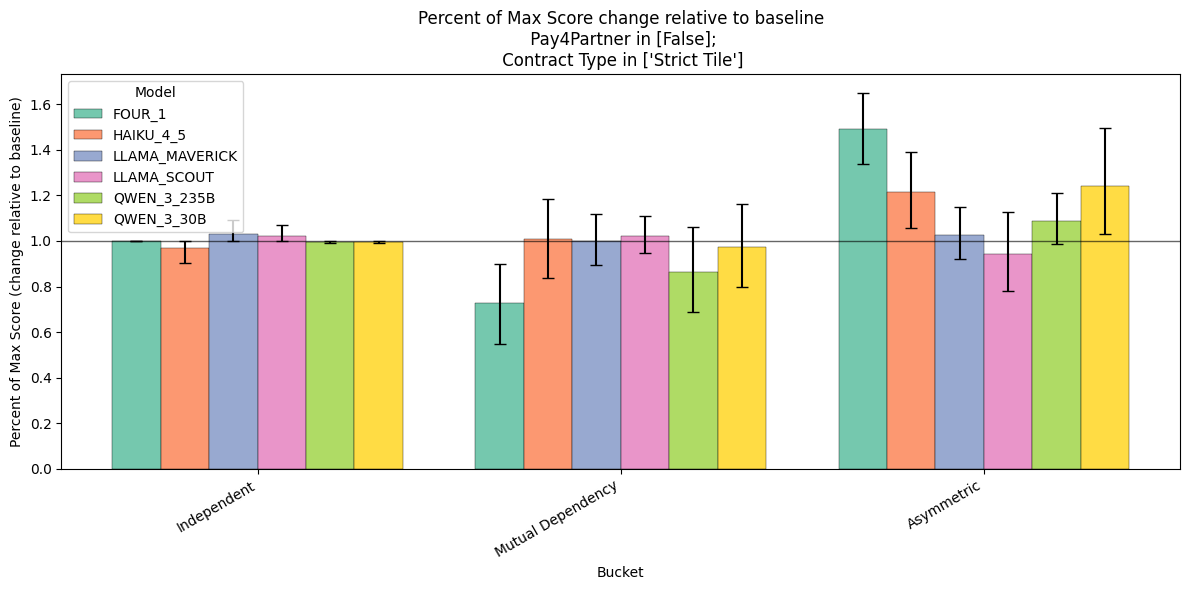

Plotting metric: Proportion of Total Points for Red Player | Contract: Strict Tile | Pay4Partner: False


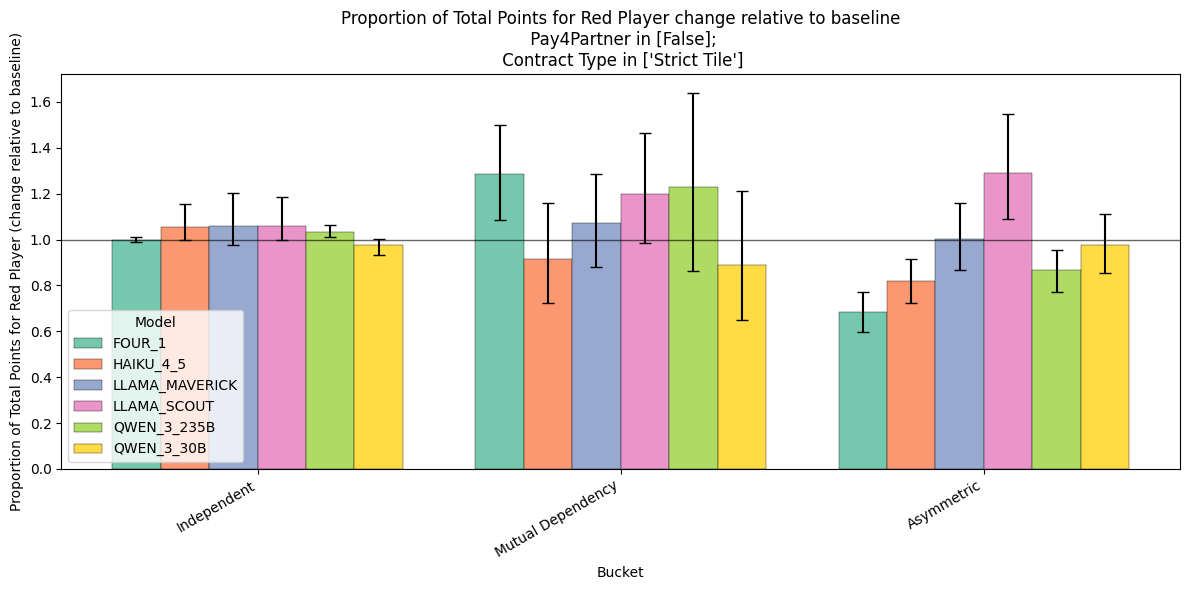

Plotting metric: Percent of Max Score | Contract: Natural Language Tile | Pay4Partner: False


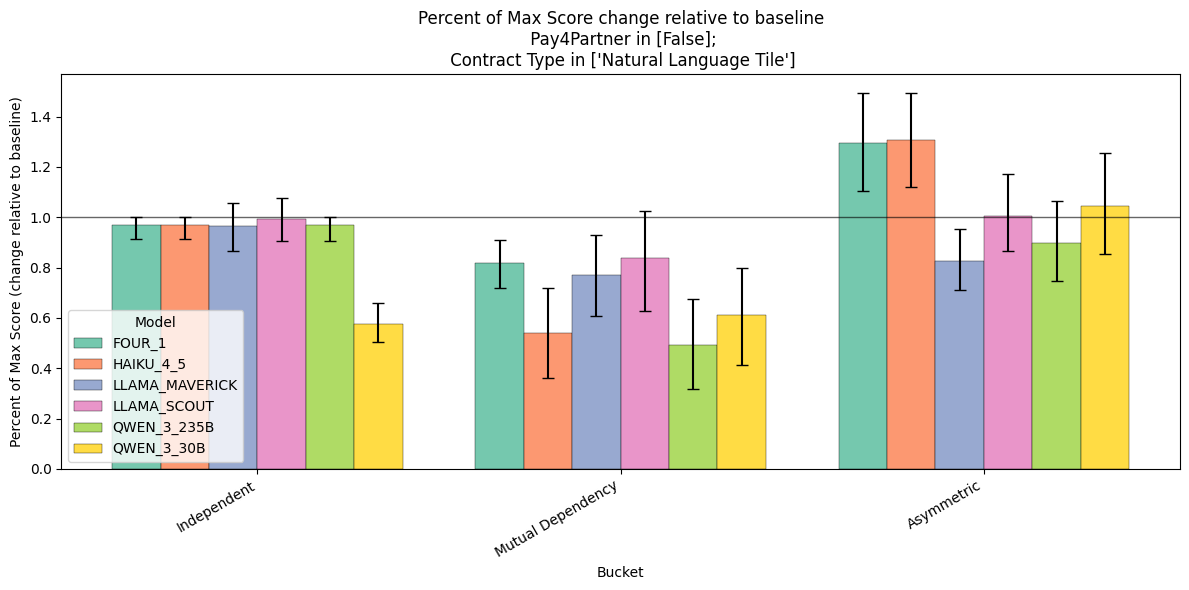

Plotting metric: Proportion of Total Points for Red Player | Contract: Natural Language Tile | Pay4Partner: False


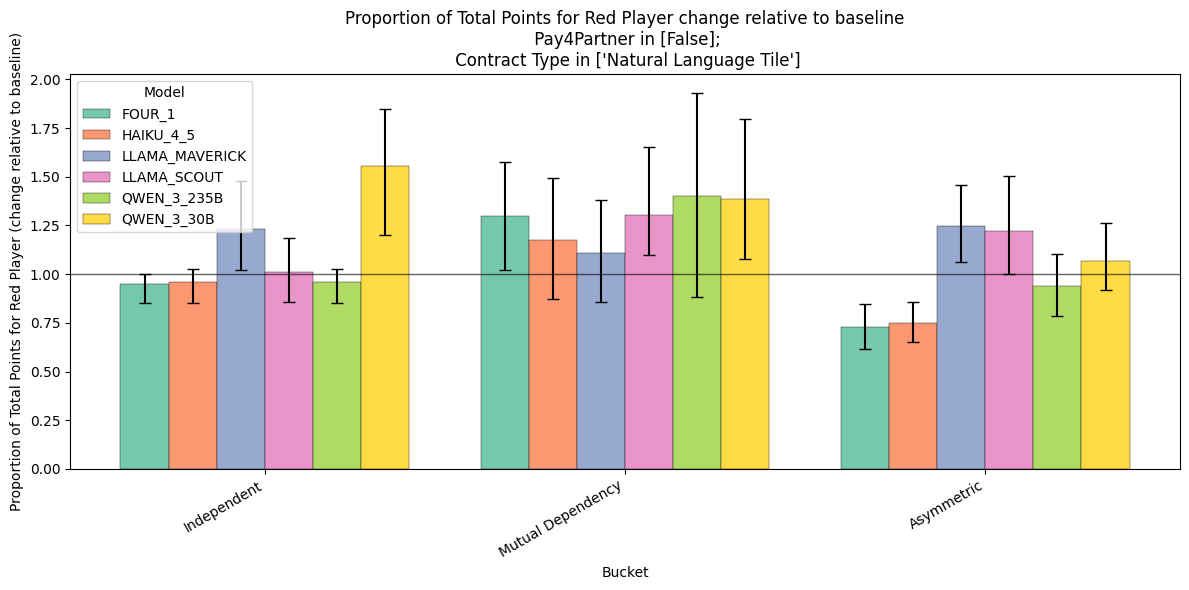

Plotting metric: Percent of Max Score | Contract: Strict Finishing | Pay4Partner: False


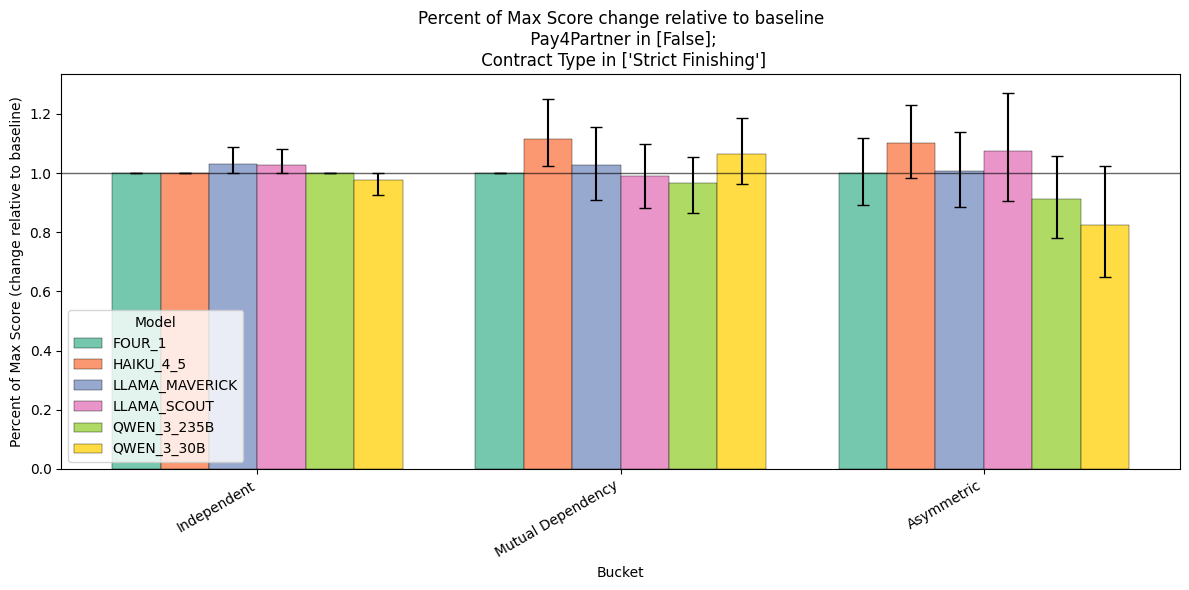

Plotting metric: Proportion of Total Points for Red Player | Contract: Strict Finishing | Pay4Partner: False


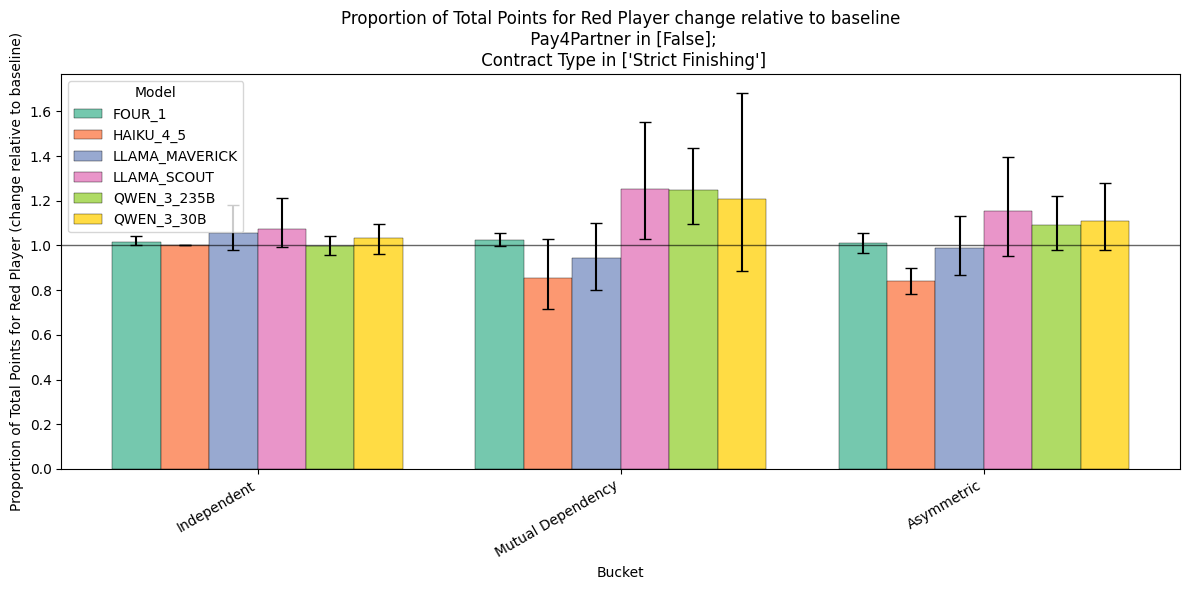

Plotting metric: Percent of Max Score | Contract: No Contract | Pay4Partner: True


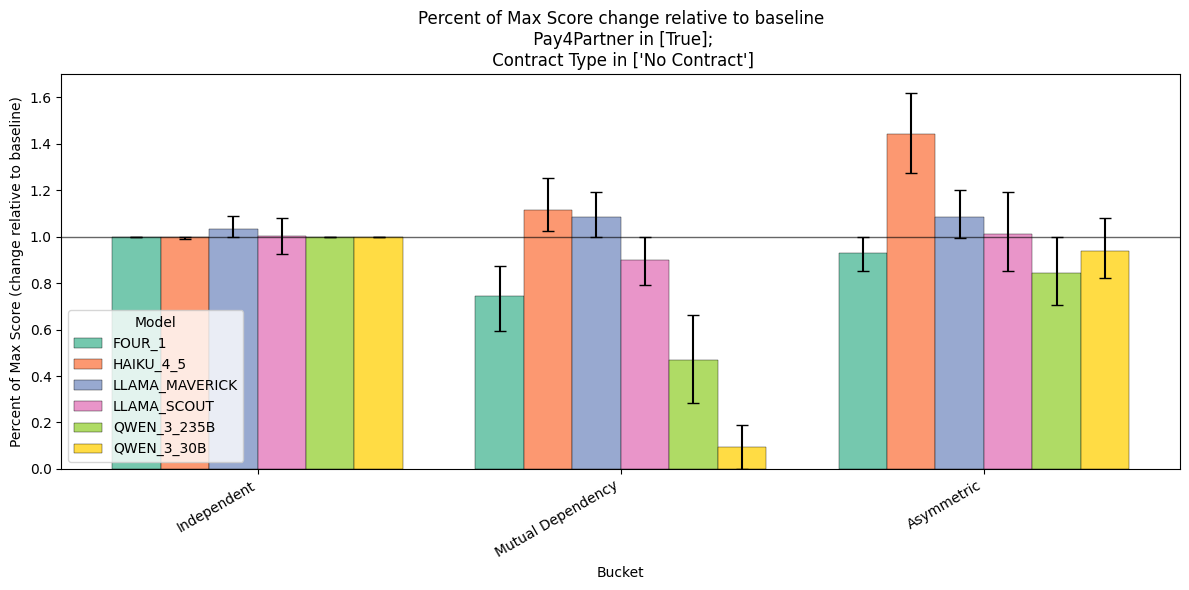

Plotting metric: Proportion of Total Points for Red Player | Contract: No Contract | Pay4Partner: True


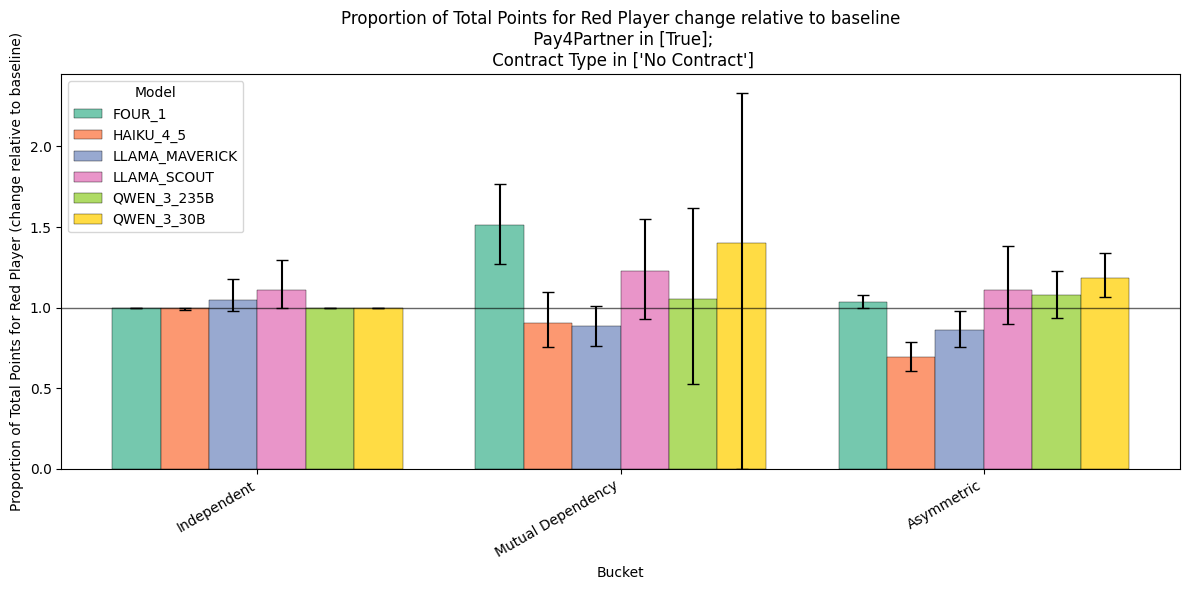

Plotting metric: Percent of Max Score | Contract: Strict Tile | Pay4Partner: True


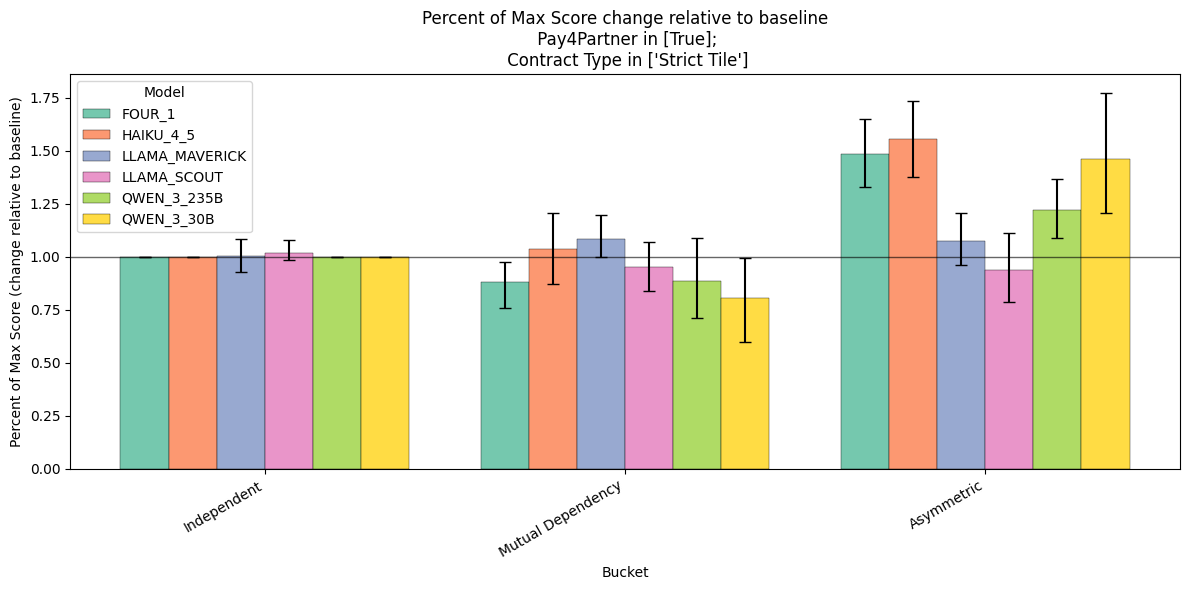

Plotting metric: Proportion of Total Points for Red Player | Contract: Strict Tile | Pay4Partner: True


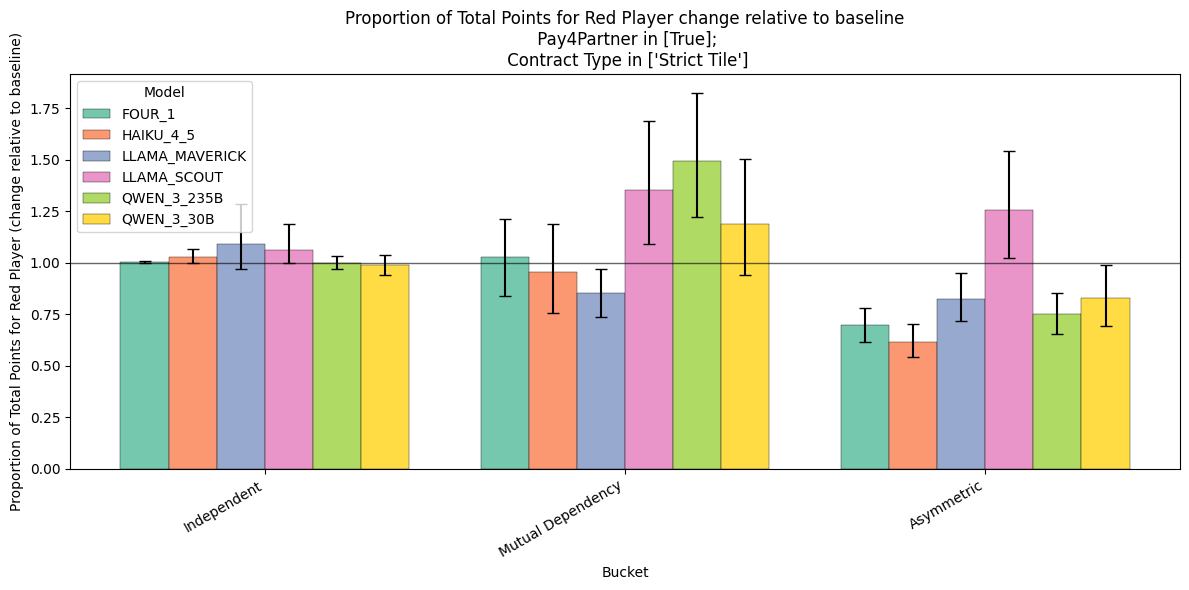

Plotting metric: Percent of Max Score | Contract: Natural Language Tile | Pay4Partner: True


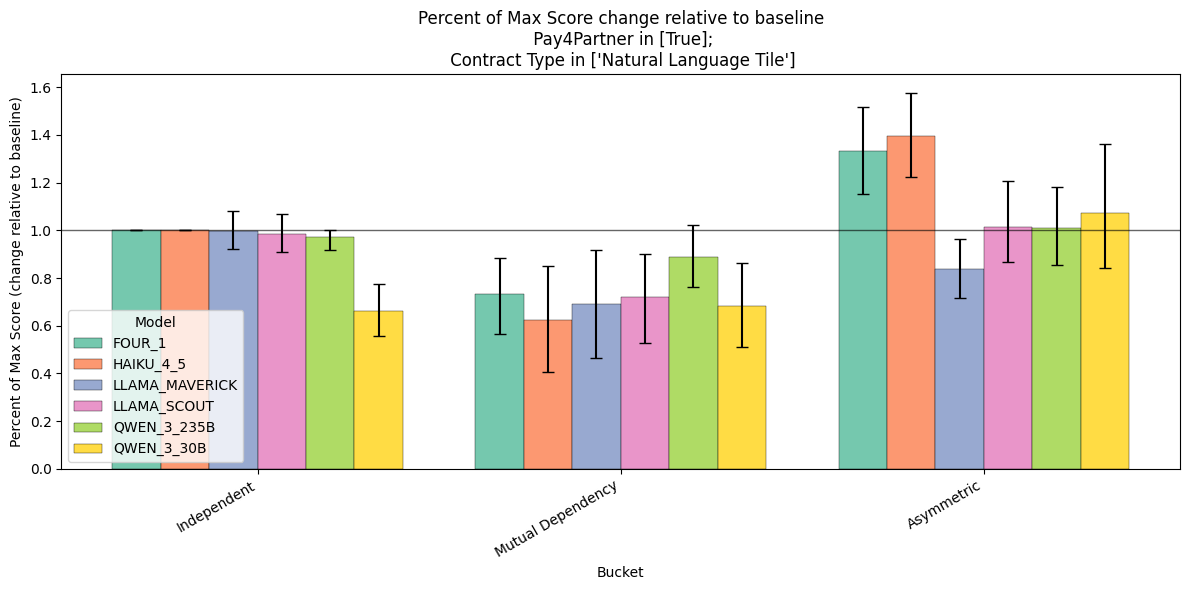

Plotting metric: Proportion of Total Points for Red Player | Contract: Natural Language Tile | Pay4Partner: True


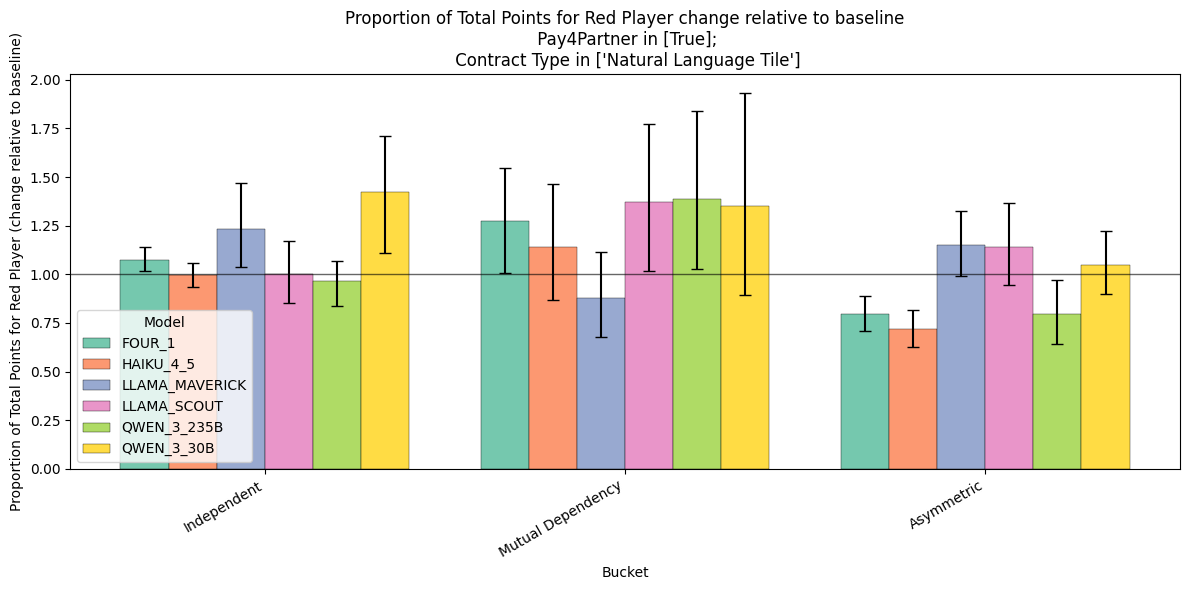

Plotting metric: Percent of Max Score | Contract: Strict Finishing | Pay4Partner: True


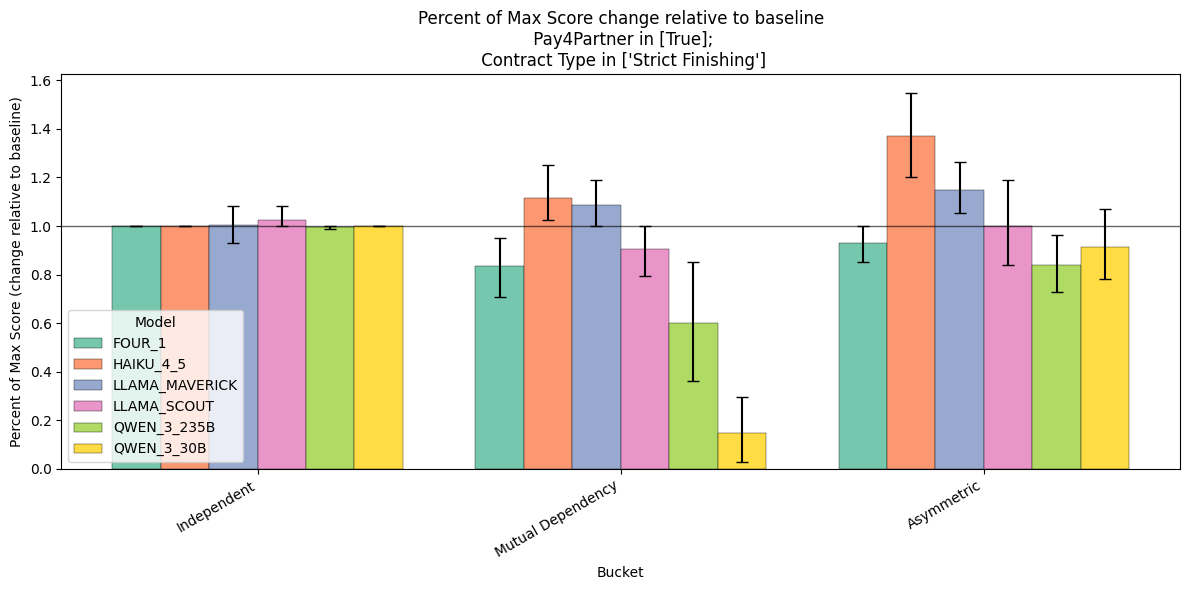

Plotting metric: Proportion of Total Points for Red Player | Contract: Strict Finishing | Pay4Partner: True


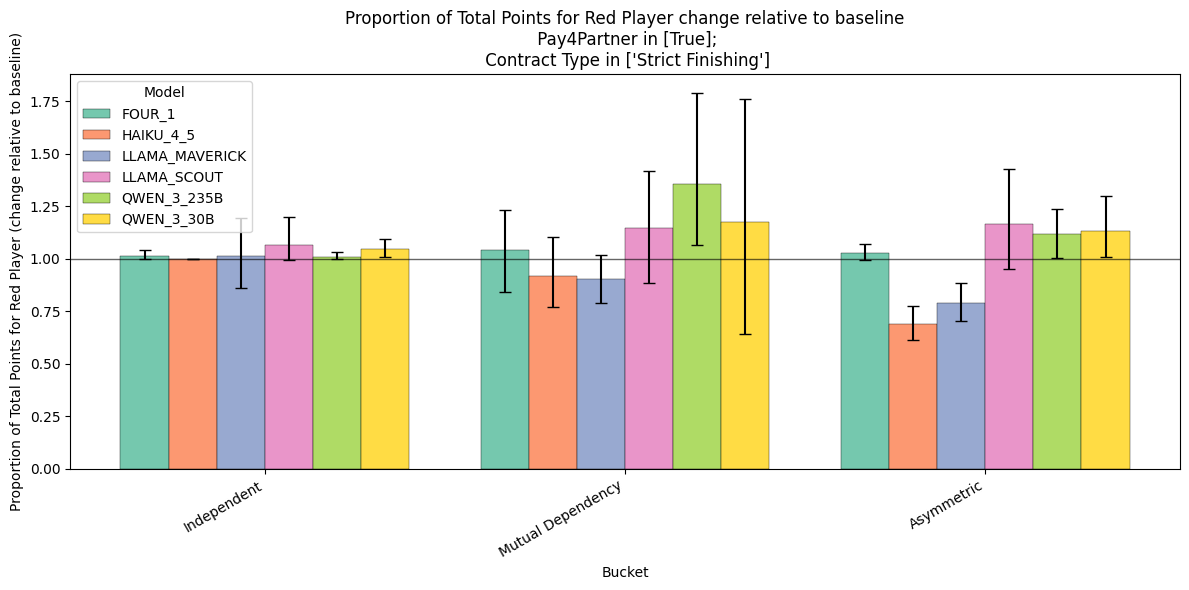

In [ ]:
metrics = [
    'Normalized Joint Reward',
    'Proportion of Total Points for Red Player',
]

contracts = ['No Contract', 'Strict Tile', 'Natural Language Tile', 'Strict Finishing']
p4p_values = [False, True]

for p4p in p4p_values:
    for contract in contracts:
        if not p4p and contract == 'No Contract':
            continue  # skip baseline
        for metric in metrics:
            print(f"Plotting metric: {metric} | Contract: {contract} | Pay4Partner: {p4p}")
            plot_bootstrap_relative_lift_bar(
                df=df_compared_to_baseline,
                metric=metric,
                x='Bucket',
                hue='Model',
                filters=[
                    ("Pay4Partner", [p4p]),
                    ("Contract Type", [contract]),
                ],
                display_filter=True,
                order=bucket_order,
                hue_order=model_order,
                # ylim=(0, 10),
            )

## Plot Both Beat Baseline for Contracts

Plotting metric: Both Players Beat Baseline


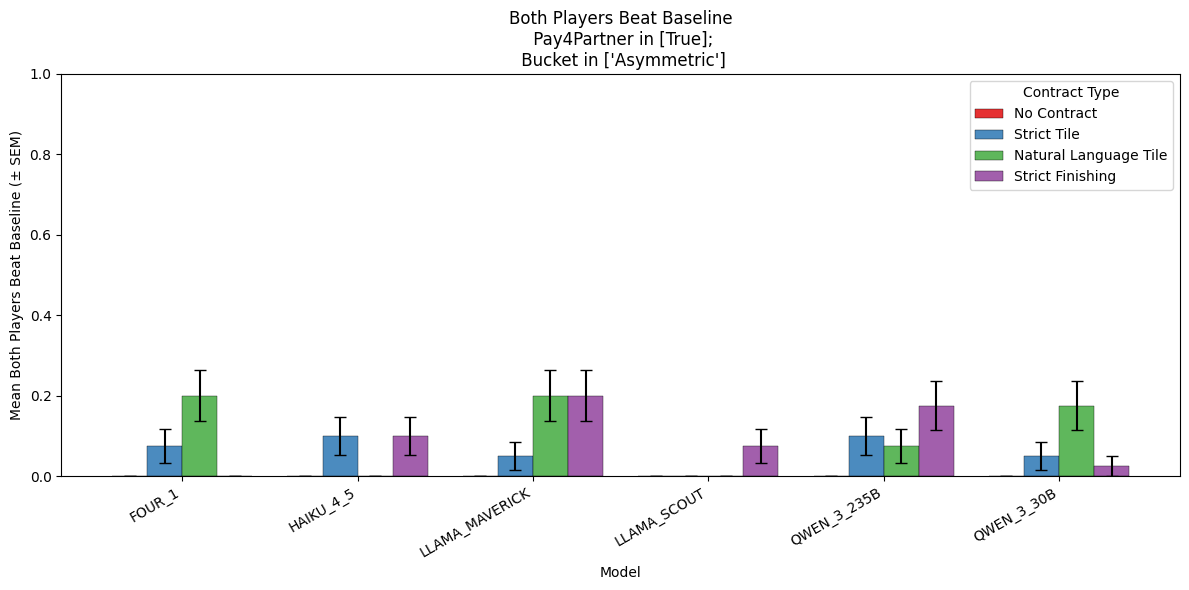

In [ ]:
metrics_cfg = [
{'df': df,
    'metric': 'Both Players Beat Baseline',
                 'x': 'Model',
                 'hue': 'Contract Type',
                 'order': model_order,
                 'hue_order': contract_order,
                 'filters':[("Pay4Partner", [True]), 
                ('Bucket', ['Asymmetric'])],
}
]

for metric_cfg in metrics_cfg:
    print(f"Plotting metric: {metric_cfg['metric']}")
    plot_mean_metric_bar(
        df=metric_cfg['df'],
        metric=metric_cfg['metric'],
        x=metric_cfg['x'],
        hue=metric_cfg.get('hue', None),
        filters=metric_cfg.get('filters', None),
        display_filter=metric_cfg.get('display_filter', True),
        order=metric_cfg.get('order', None),
        hue_order=metric_cfg.get('hue_order', None),
        palette="Set1",
    )

## Per Player Points

Saved figure to analysis/figures/player_scores_by_contract_for_Asymmetric_boards.pdf


/var/folders/v4/m284bsbd28v34f76996xhy_w0000gn/T/ipykernel_52960/1304727900.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Contract Type', 'Model', 'Player'], as_index=False)['Score']
/var/folders/v4/m284bsbd28v34f76996xhy_w0000gn/T/ipykernel_52960/1304727900.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Contract Type', 'Player'], as_index=False)['Score']
/var/folders/v4/m284bsbd28v34f76996xhy_w0000gn/T/ipykernel_52960/1304727900.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to

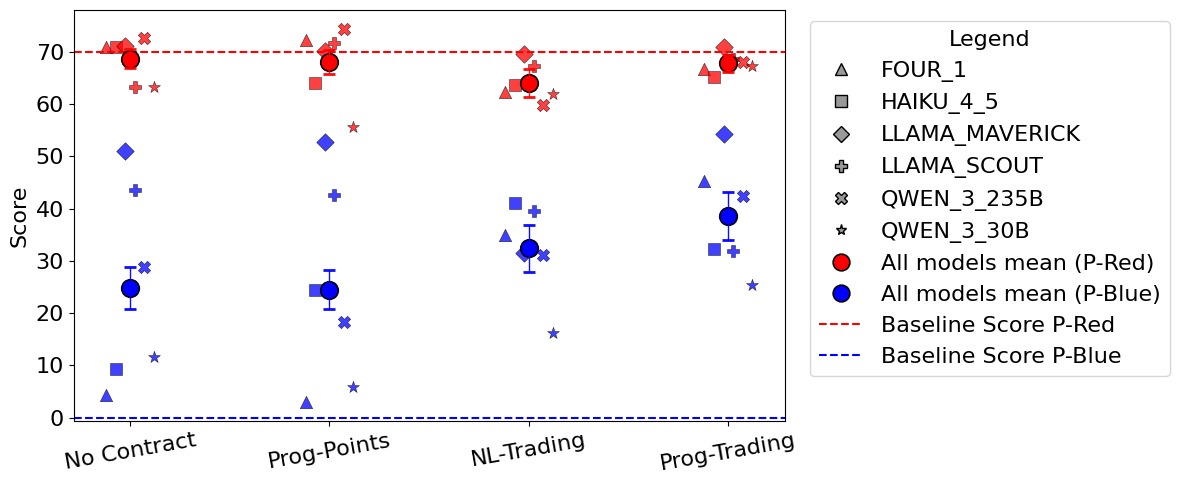

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

RT = df.copy()

bucket = 'Asymmetric'
p4p = False
subset = RT[(RT['Bucket'] == bucket) & (RT['Pay4Partner'] == p4p)].copy()

# Contract order
order = contract_order
subset['Contract Type'] = pd.Categorical(subset['Contract Type'], categories=order, ordered=True)

# Long format
df_long = subset.melt(
    id_vars=['Contract Type', 'Model'],
    value_vars=['Score P-Red', 'Score P-Blue'],
    var_name='Player',
    value_name='Score',
)
df_long['Player'] = df_long['Player'].map({'Score P-Red': 'P-Red', 'Score P-Blue': 'P-Blue'})
player_order = ['P-Red', 'P-Blue']

# Collapse to ONE point per (Contract, Model, Player)
model_means = (
    df_long
    .groupby(['Contract Type', 'Model', 'Player'], as_index=False)['Score']
    .mean()
)
model_means['Player'] = pd.Categorical(model_means['Player'], categories=player_order, ordered=True)
model_means = model_means.sort_values(['Contract Type', 'Model', 'Player'])

# Averages across all models (per contract, per player)
avg_long = (
    model_means
    .groupby(['Contract Type', 'Player'], as_index=False)['Score']
    .mean()
)
avg_long['Player'] = pd.Categorical(avg_long['Player'], categories=player_order, ordered=True)
avg_long = avg_long.sort_values(['Contract Type', 'Player'])

avg_stats = (
    df_long
    .groupby(['Contract Type', 'Player'])
    .agg(
        mean_score=('Score', 'mean'),
        sd=('Score', 'std'),
        n=('Score', 'count'),
    )
    .reset_index()
)
avg_stats['sem'] = avg_stats['sd'] / np.sqrt(avg_stats['n'])
avg_stats['Player'] = pd.Categorical(avg_stats['Player'], categories=player_order, ordered=True)
avg_stats['ci95'] = 1.96 * avg_stats['sem']
avg_stats.loc[avg_stats['n'] <= 1, 'ci95'] = 0.0  # CI undefined for n=1; show 0-length bars
avg_stats = avg_stats.sort_values(['Contract Type', 'Player'])


# Baselines
baseline_p0 = subset['Non-Cooperative Baseline P-Red'].mean()
baseline_p1 = subset['Non-Cooperative Baseline P-Blue'].mean()

# Models + distinct shapes (NO circles reserved for means)
models = sorted(model_means['Model'].dropna().unique().tolist())
model_markers = ['^', 's', 'D', 'P', 'X', '*', 'v', '<', '>', 'H']  # plenty; no 'o'
if len(models) > len(model_markers):
    raise ValueError(f"Not enough marker shapes for {len(models)} models; add more to model_markers.")

model_to_marker = {m: model_markers[i] for i, m in enumerate(models)}

# Color by player (requested)
player_color = {'P-Red': 'red', 'P-Blue': 'blue'}


fig, ax = plt.subplots(figsize=(12, 5))

# Deterministic x positions
xpos = {ct: i for i, ct in enumerate(order)}

# Fixed offsets for models within each contract (evenly spaced)
# Keep within about +/-0.25 so it doesn't spill into neighboring categories.
span = 0.12
offsets = (
    [0.0] if len(models) == 1
    else list(np.linspace(-span, span, num=len(models)))
)
model_to_offset = {m: offsets[i] for i, m in enumerate(models)}

# --- Per-model points: deterministic offsets (replaces jitter) ---
for player in player_order:
    d_player = model_means[model_means['Player'] == player].copy()

    for m in models:
        d = d_player[d_player['Model'] == m].copy()
        if d.empty:
            continue

        # numeric x for each contract with model-specific offset
        xs = d['Contract Type'].map(xpos).to_numpy() + model_to_offset[m]
        ys = d['Score'].to_numpy()

        ax.scatter(
            xs,
            ys,
            s=80,  # matplotlib uses area; roughly match seaborn size=7
            marker=model_to_marker[m],
            c=player_color[player],
            alpha=0.75,
            edgecolors='k',
            linewidths=0.4,
            zorder=2,
        )

# --- Means: big centered circles (no offset) ---

for player in player_order:
    d = avg_stats[avg_stats['Player'] == player].copy()
    xs = d['Contract Type'].map(xpos).to_numpy()
    ys = d['mean_score'].to_numpy()
    yerr = np.nan_to_num(d['ci95'].to_numpy(), nan=0.0)

    # Mean marker
    ax.scatter(
        xs,
        ys,
        s=160,
        marker='o',
        c=player_color[player],
        alpha=1.0,
        edgecolors='k',
        linewidths=1.2,
        zorder=6,
    )

    # Error bars
    ax.errorbar(
        xs,
        ys,
        yerr=yerr,
        fmt='none',
        ecolor=player_color[player],
        elinewidth=1.0,
        capsize=4,
        capthick=2.0,
        alpha=0.95,
        zorder=10,
    )


# Baseline lines
ax.axhline(y=baseline_p0, color='red', linestyle='--', linewidth=1.5, label='Baseline Score P-Red')
ax.axhline(y=baseline_p1, color='blue', linestyle='--', linewidth=1.5, label='Baseline Score P-Blue')

# X axis ticks from numeric positions
ax.set_xticks(range(len(order)))
ax.set_xticklabels(order, rotation=10, fontsize=DEFAULT_FONT_SIZE)

# ax.set_xlabel('Contract Type')
ax.set_ylabel('Score', fontsize=DEFAULT_FONT_SIZE)
ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=DEFAULT_FONT_SIZE)
# ax.set_title(f"Player Scores by Contract Type for {bucket} Boards")


# Build custom legend: models (shapes) + means + baselines
legend_handles = []

# Model legend (shape only; use neutral color)
legend_handles += [
    Line2D([0], [0], marker=model_to_marker[m], linestyle='None',
           markerfacecolor='0.6', markeredgecolor='k', markersize=8, label=m)
    for m in models
]

# (Removed) Color legend for players — red/blue in plot is already obvious

# Mean legend (bigger circles)
legend_handles += [
    Line2D([0], [0], marker='o', linestyle='None', color=player_color['P-Red'],
           markerfacecolor=player_color['P-Red'], markeredgecolor='k',
           markeredgewidth=1.2, markersize=12, label='All models mean (P-Red)'),
    Line2D([0], [0], marker='o', linestyle='None', color=player_color['P-Blue'],
           markerfacecolor=player_color['P-Blue'], markeredgecolor='k',
           markeredgewidth=1.2, markersize=12, label='All models mean (P-Blue)'),
]

# Baselines
legend_handles += [
    Line2D([0], [0], color='red', linestyle='--', linewidth=1.5, label='Baseline Score P-Red'),
    Line2D([0], [0], color='blue', linestyle='--', linewidth=1.5, label='Baseline Score P-Blue'),
]

ax.legend(handles=legend_handles, title='Legend', bbox_to_anchor=(1.02, 1), loc='upper left',
          fontsize=DEFAULT_FONT_SIZE,      # legend text
    title_fontsize=DEFAULT_FONT_SIZE)
name = f'player_scores_by_contract_for_{bucket}_boards'
output_path = f"{output_folder}/{name}.pdf"
plt.savefig(output_path, format="pdf", bbox_inches="tight")
print(f"Saved figure to {output_path}")

plt.tight_layout()
plt.show()

## Mean Join Reward and Equality

## Other metrics

In [ ]:
contract_order = ['No Contract', 'Strict Finishing', 'Natural Language Tile', 'Strict Tile',   ]

In [ ]:
subset = df[(df["Bucket"] == bucket) 
            & (df["Pay4Partner"] == False) 
            # & (df["Contract Type"].isin(contracts))
            ].copy()

subset.groupby('total_trade_volume')['Run ID'].count()

total_trade_volume
0     133
2       8
3      10
4     107
5      87
6      40
7      23
8      17
9      14
10     14
11      9
12      4
13      2
14      2
15      2
16      4
18      1
20      1
22      2
Name: Run ID, dtype: int64

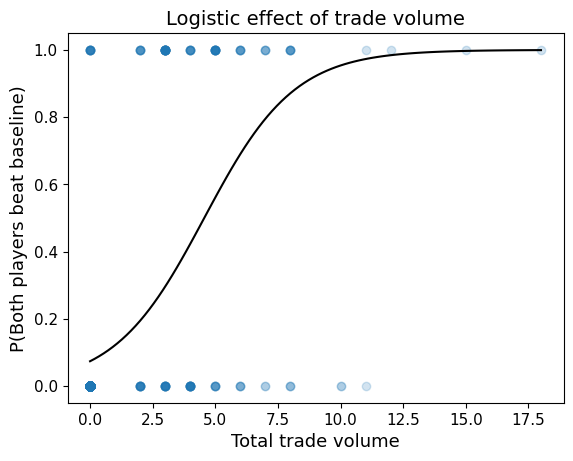

In [ ]:
# import numpy as np
# from sklearn.linear_model import LogisticRegression

# bucket = 'Asymmetric'
# contracts = ['Strict Finishing', 'Natural Language Tile']

# subset = df[(df["Bucket"] == bucket) 
#             & (df["Pay4Partner"] == False) 
#             & (df["Contract Type"].isin(contracts))
#             & (df['contract_accepted'] == 1)
#             ].copy()


# # X must be 2D
# X = subset[["total_trade_volume"]].values
# y = subset["Both Players Beat Baseline"].values

# model = LogisticRegression(solver="lbfgs")
# model.fit(X, y)

# import matplotlib.pyplot as plt

# x_vals = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
# p_vals = model.predict_proba(x_vals)[:, 1]

# plt.scatter(X, y, alpha=0.2)
# plt.plot(x_vals, p_vals, color="black")
# plt.xlabel("Total trade volume")
# plt.ylabel("P(Both players beat baseline)")
# plt.title("Logistic effect of trade volume")
# plt.show()

In [ ]:
# beta = model.coef_[0][0]
# odds_ratio = np.exp(beta)

# print(f"β (log-odds per chip): {beta:.3f}")
# print(f"Odds ratio per chip: {odds_ratio:.3f}")

β (log-odds per chip): 0.556
Odds ratio per chip: 1.744


In [ ]:
contracts = ['Strict Tile', 'Natural Language Tile']
bucket = 'Asymmetric'
subset = df[(df["Bucket"] == bucket) 
            & (df["Pay4Partner"] == False) 
            & (df["Contract Type"].isin(contracts))
            # & (df['contract_accepted'] == 1)
            ].copy()


p_bbb_w_trades = subset[subset['total_trade_volume'] > 0]['Both Players Beat Baseline'].mean()
p_bbb_wo_trades = subset[subset['total_trade_volume'] == 0]['Both Players Beat Baseline'].mean()
print(f"P(Both Beat Baseline | trades > 0) = {p_bbb_w_trades:.3f}")
print(f"P(Both Beat Baseline | trades = 0) = {p_bbb_wo_trades:.3f}")

P(Both Beat Baseline | trades > 0) = 0.462
P(Both Beat Baseline | trades = 0) = 0.047


In [ ]:
p_blue_finished = subset[subset['total_trade_volume'] > 0]['R_beats_baseline'].mean()
p_finished = subset[subset['total_trade_volume'] == 0]['R_beats_baseline'].mean()
print(f"P(Red Beats baseline | trades > 0) = {p_blue_finished:.3f}")
print(f"P(Red Beats baseline| trades = 0) = {p_finished:.3f}")



P(Red Beats baseline | trades > 0) = 0.564
P(Red Beats baseline| trades = 0) = 0.121


In [ ]:
p_blue_finished = subset[subset['total_trade_volume'] > 0]['Reached Goal P-Blue'].mean()
p_finished = subset[subset['total_trade_volume'] == 0]['Reached Goal P-Blue'].mean()
print(f"P(Blue finishes | trades > 0) = {p_blue_finished:.3f}")
print(f"P(Blue finises | trades = 0) = {p_finished:.3f}")



P(Blue finishes | trades > 0) = 0.838
P(Blue finises | trades = 0) = 0.388


In [ ]:
df[df['contract_accepted'] == 0].shape

(1376, 115)

β (log-odds per chip): 0.556
Odds ratio per chip: 1.744


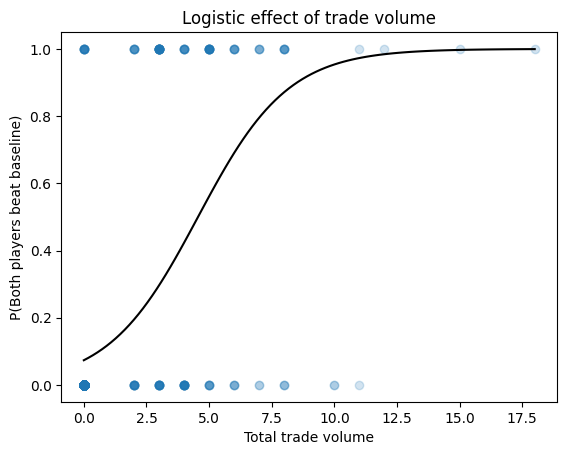

In [ ]:
df

Obviously trading is a strong predictor of success when there are no contracts, but even when there are contracts?

In [ ]:
import statsmodels.api as sm

X_sm = sm.add_constant(subset["total_trade_volume"])
y_sm = subset["Both Players Beat Baseline"]

model_sm = sm.Logit(y_sm, X_sm).fit()
print(model_sm.summary())

Optimization terminated successfully.
         Current function value: 0.355116
         Iterations 6
                               Logit Regression Results                               
Dep. Variable:     Both Players Beat Baseline   No. Observations:                  480
Model:                                  Logit   Df Residuals:                      478
Method:                                   MLE   Df Model:                            1
Date:                        Tue, 27 Jan 2026   Pseudo R-squ.:                  0.2777
Time:                                17:16:17   Log-Likelihood:                -170.46
converged:                               True   LL-Null:                       -235.98
Covariance Type:                    nonrobust   LLR p-value:                 2.428e-30
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.545

On how many boards does each contract type come out on top? (or tied first)
Treat three buckets independently
What do we mean by come out on top:
Normalised total score 
Asymmetric: both beat baseline 
m


## Which contract is best per grid?

In [ ]:
df = format_data(full_df)
p4p = False
bucket = ['Mutual Dependency', 'Asymmetric' ]
subset = df[
    (df["Bucket"].isin(bucket)) &
    (df["Pay4Partner"] == p4p)
].copy()

print(f"{len(subset)} rows after filtering; {subset['Grid ID'].nunique()} grids")

# We want one row per (Grid ID, Contract Type) with aggregated metrics.
# Here I take the mean per grid+contract; adjust agg if needed.
agg = (
    subset
    .groupby(["Grid ID", "Contract Type"], as_index=False)
    .agg(
        norm_total_score=("Normalized Joint Reward", "mean"),
        both_beat_baseline=("Both Players Beat Baseline", "mean"),  # proportion in [0,1]
    )
)

# ---- Rank contracts within each grid for each metric ----
# Higher is better, so use ascending=False. Rank 1 = best.
agg["rank_norm_score"] = agg.groupby("Grid ID")["norm_total_score"] \
                            .rank(method="min", ascending=False)
agg["rank_both_beat"] = agg.groupby("Grid ID")["both_beat_baseline"] \
                           .rank(method="min", ascending=False)

# Optional: keep only integer ranks (they will be floats from rank())
agg["rank_norm_score"] = agg["rank_norm_score"].astype(int)
agg["rank_both_beat"] = agg["rank_both_beat"].astype(int)

print("Per-grid, per-contract rankings (head):")
display(agg.head())

# ---- How often each contract is 1st / 2nd / 3rd / ... for each metric? ----
# For Normalized Joint Reward
rank_counts_norm = (
    agg
    .groupby(["Contract Type", "rank_norm_score"])
    .size()
    .reset_index(name="count")
    .pivot(index="Contract Type", columns="rank_norm_score", values="count")
    .fillna(0)
    .astype(int)
    .rename_axis(columns="Rank (1=best)")
)

print("\nHow often each contract is 1st / 2nd / 3rd / ... by Normalized Joint Reward:")
display(rank_counts_norm)

# For Both Players Beat Baseline (actually proportion across games in that grid+contract)
rank_counts_both = (
    agg
    .groupby(["Contract Type", "rank_both_beat"])
    .size()
    .reset_index(name="count")
    .pivot(index="Contract Type", columns="rank_both_beat", values="count")
    .fillna(0)
    .astype(int)
    .rename_axis(columns="Rank (1=best)")
)

print("\nHow often each contract is 1st / 2nd / 3rd / ... by Both Players Beat Baseline:")
display(rank_counts_both)


Model Pair LLAMA_MAVERICK-LLAMA_MAVERICK has 640 rows.
Model Pair QWEN_3_235B-QWEN_3_235B has 640 rows.
Model Pair QWEN_3_30B-QWEN_3_30B has 640 rows.
Model Pair LLAMA_SCOUT-LLAMA_SCOUT has 640 rows.
Model Pair FOUR_1-FOUR_1 has 640 rows.
Model Pair HAIKU_4_5-HAIKU_4_5 has 640 rows.
Formatted data with 6 unique model pairs,  3840 total rows
1440 rows after filtering; 60 grids
Per-grid, per-contract rankings (head):


,Grid ID,Contract Type,norm_total_score,both_beat_baseline,rank_norm_score,rank_both_beat
0,80,NL-Trading,0.333333,0.333333,4,4
1,80,No Contract,0.916667,0.833333,3,3
2,80,Prog-Points,1.000000,1.000000,1,1
3,80,Prog-Trading,1.000000,1.000000,1,1
4,81,NL-Trading,0.613095,0.333333,4,4



How often each contract is 1st / 2nd / 3rd / ... by Normalized Joint Reward:


Rank (1=best),1,2,3,4
Contract Type,,,,
NL-Trading,11,14,11,24
No Contract,16,13,18,13
Prog-Points,20,16,12,12
Prog-Trading,28,12,14,6



How often each contract is 1st / 2nd / 3rd / ... by Both Players Beat Baseline:


Rank (1=best),1,2,3,4
Contract Type,,,,
NL-Trading,9,11,17,23
No Contract,27,22,7,4
Prog-Points,46,7,5,2
Prog-Trading,17,18,21,4


Within models there is a lot of noise making it difficult to observe which contract types perform best. However by aggregating across models and looking at which contract type performs best on each grid, the quality of different models becomes more clear. For mutual dependency boards the Strict Finishing contract results in the highest average Normalized Joint Reward across all contract types in 15 of the 20 grids. For asymmetric boards the Strict Finishing contract results in the highest average Both Beat Baseline Score across all contract types in 26 of the 40 grids. Meanwhile the Strict Tile was the best performing for Normalized Joint Reward, performing the best in 23 of the 40 grids.

Model Pair LLAMA_MAVERICK-LLAMA_MAVERICK has 640 rows.
Model Pair QWEN_3_235B-QWEN_3_235B has 640 rows.
Model Pair QWEN_3_30B-QWEN_3_30B has 640 rows.
Model Pair LLAMA_SCOUT-LLAMA_SCOUT has 640 rows.
Model Pair FOUR_1-FOUR_1 has 640 rows.
Model Pair HAIKU_4_5-HAIKU_4_5 has 640 rows.
Formatted data with 6 unique model pairs,  3840 total rows
960 rows after filtering; 40 grids


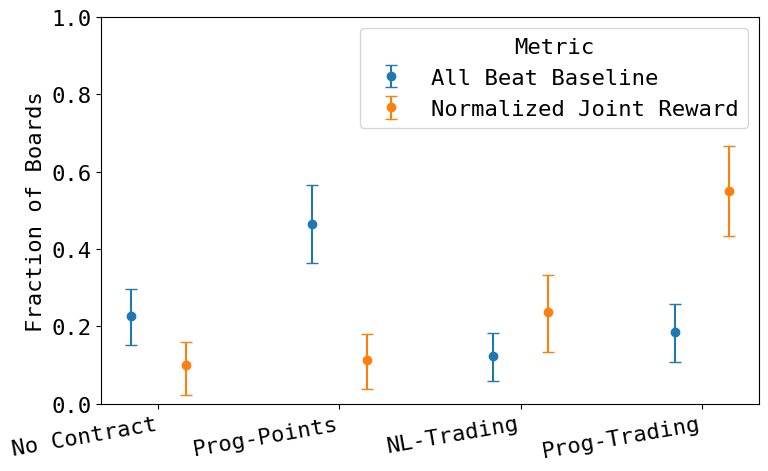

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = format_data(full_df)
p4p = False
bucket = [ 'Asymmetric' ]
subset = df[
    df["Bucket"].isin(bucket) &
    (df["Pay4Partner"] == p4p)
].copy()


print(f"{len(subset)} rows after filtering; {subset['Grid ID'].nunique()} grids")

# One row per (Grid ID, Contract Type) with aggregated metrics.
agg = (
    subset
    .groupby(["Grid ID", "Contract Type"], as_index=False)
    .agg(
        norm_total_score=("Normalized Joint Reward", "mean"),
        all_beat_baseline=("All Beat Baseline", "mean"),
    )
)

# ----- fractional "best" indicators per grid, per contract, per metric -----
# Normalized Joint Reward
g_norm = agg.groupby("Grid ID")["norm_total_score"]
max_norm = g_norm.transform("max")
n_top_norm = g_norm.transform(lambda s: (s == s.max()).sum())

agg["best_norm_score"] = 0.0
mask_top_norm = agg["norm_total_score"] == max_norm
agg.loc[mask_top_norm, "best_norm_score"] = 1.0 / n_top_norm[mask_top_norm]

# all Players Beat Baseline
g_all = agg.groupby("Grid ID")["all_beat_baseline"]
max_all = g_all.transform("max")
n_top_all = g_all.transform(lambda s: (s == s.max()).sum())

agg["best_all_beat"] = 0.0
mask_top_all = agg["all_beat_baseline"] == max_all
agg.loc[mask_top_all, "best_all_beat"] = 1.0 / n_top_all[mask_top_all]

# Long format over metrics so we can easily use hue
agg_long = agg.melt(
    id_vars=["Grid ID", "Contract Type"],
    value_vars=["best_norm_score", "best_all_beat"],
    var_name="Metric",
    value_name="best_mass",
)
metric_map = {
    "best_norm_score": "Normalized Joint Reward",
    "best_all_beat": "All Beat Baseline",
}
agg_long["Metric"] = agg_long["Metric"].map(metric_map)
if bucket != ['Asymmetric']:
    agg_long = agg_long[agg_long["Metric"] == "Normalized Joint Reward"]

# ----- bootstrap over grids for CIs -----
rng = np.random.default_rng(0)
n_boot = 5000

grid_ids = agg_long["Grid ID"].unique()
n_grids = len(grid_ids)

# Prepare structure: we'll accumulate bootstrap means in a dict keyed by (contract, metric)
boot_means = {}

contracts = sorted(agg_long["Contract Type"].unique())
metrics = sorted(agg_long["Metric"].unique())

for contract in contracts:
    for metric in metrics:
        key = (contract, metric)
        boot_means[key] = np.empty(n_boot, dtype=float)

for b in range(n_boot):
    # sample grids with replacement
    sampled_grids = rng.choice(grid_ids, size=n_grids, replace=True)
    boot_sample = agg_long[agg_long["Grid ID"].isin(sampled_grids)].copy()

    # average best_mass across sampled grids for each (Contract Type, Metric)
    means = (
        boot_sample
        .groupby(["Contract Type", "Metric"], as_index=False)["best_mass"]
        .mean()
    )
    for _, row in means.iterrows():
        key = (row["Contract Type"], row["Metric"])
        boot_means[key][b] = row["best_mass"]

# Summarize bootstrap means: overall mean + 95% CI
rows = []
for contract in contracts:
    for metric in metrics:
        vals = boot_means[(contract, metric)]
        mean_val = np.nanmean(vals)
        lo, hi = np.nanpercentile(vals, [2.5, 97.5])
        rows.append(
            dict(
                Contract_Type=contract,
                Metric=metric,
                mean_best=mean_val,
                ci_lower=lo,
                ci_upper=hi,
            )
        )

summary = pd.DataFrame(rows)
order = contract_order
# keep only those present, in that order
x_order = [c for c in order if c in summary["Contract_Type"].unique()]

summary["Contract_Type"] = pd.Categorical(
    summary["Contract_Type"],
    categories=x_order,
    ordered=True,
)

# ----- plot: contracts on x, metrics as hue, bootstrap CIs as error bars -----
plt.figure(figsize=(8, 5))

hue_order = metrics  # e.g. ["Normalized Joint Reward"] or both

n_metrics = len(hue_order)

for i, metric in enumerate(hue_order):
    d = summary[summary["Metric"] == metric].copy().set_index("Contract_Type")
    d = d.loc[x_order]  # ensure correct order

    # Center when only one metric, side-by-side when two
    if n_metrics == 1:
        offset = 0.0
    else:
        offset = -0.15 + i * (0.30 / (n_metrics - 1))

    xs = np.arange(len(x_order)) + offset

    plt.errorbar(
        xs,
        d["mean_best"],
        yerr=[
            d["mean_best"] - d["ci_lower"],
            d["ci_upper"] - d["mean_best"],
        ],
        fmt="o",
        label=metric,
        capsize=4,
        elinewidth=1.5,
    )

plt.ylim(0, 1.0)
plt.xticks(
    np.arange(len(x_order)),
    x_order,
    rotation=10,
    ha="right",
    fontsize=16,
)
plt.ylabel("Fraction of Boards", fontsize=16)
plt.legend(title="Metric", fontsize=16)
plt.tight_layout()
plt.savefig(
    f"{output_folder}/contract_best_fraction_by_metric_{bucket}_p4p_{p4p}.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

In [32]:
df['Format Errors'].value_counts()

Format Errors
0    3840
Name: count, dtype: int64

## Showing Paths on Best and worst grids

In [10]:
df[(df['Contract Type'] == 'No Contract') & (df['Bucket'] == 'Mutual Dependency') & (df['Pay4Partner'] == False)].groupby('Grid ID')['Normalized Joint Reward'].mean()

Grid ID
80    0.916667
81    0.904762
82    0.988095
83    1.000000
84    0.672619
85    1.000000
86    0.934524
87    0.916667
88    0.916667
89    1.000000
90    1.000000
91    0.839286
92    0.916667
93    1.000000
94    1.000000
95    1.000000
96    0.988095
97    0.904762
98    1.000000
99    0.750000
Name: Normalized Joint Reward, dtype: float64

In [13]:
worst_md_grid = df[(df['Contract Type'] == 'No Contract') & (df['Bucket'] == 'Mutual Dependency') & (df['Pay4Partner'] == False)].groupby('Grid ID')['Normalized Joint Reward'].mean().idxmax()
print(f"Worst Mutual Dependency grid ID: {worst_md_grid}, mean Normalized Joint Reward: {df[(df['Grid ID'] == worst_md_grid) &(df['Contract Type'] == 'No Contract') & (df['Bucket'] == 'Mutual Dependency') & (df['Pay4Partner'] == False)]['Normalized Joint Reward'].mean():.3f}")

Worst Mutual Dependency grid ID: 83, mean Normalized Joint Reward: 1.000


## Heatmap of Grid Performance

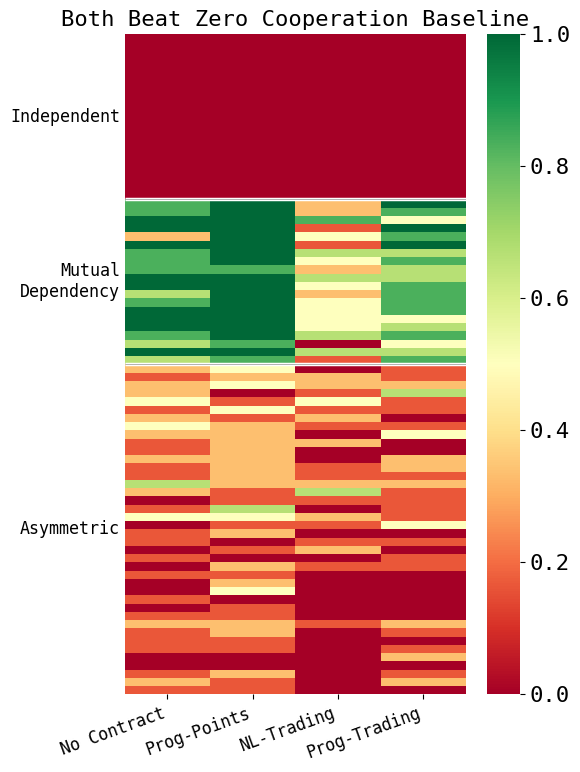

In [119]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_grid_contract_heatmap(
    df: pd.DataFrame,
    metric: str,
    buckets: list[str] | None = None,
    p4p: bool | None = False,
    contract_order: list[str] | None = None,
    agg: str = "mean",
    cmap: str = "RdYlGn",                  # green=high, red=low
    figsize: tuple[int, int] | None = None,
    show_grid_labels: bool = False,
    show_contract_labels: bool = True,
    robust: bool = False,                   # easier to use fixed 0..1 scale
    vmin: float | None = 0.0,               # red at 0
    vmax: float | None = 1.0,               # green at 1
    title: str | None = None,
    # bucket_label_fontsize: int = 12,
    bucket_linewidth: float = 2.0,
):
    """
    Heatmap of metric aggregated across all model pairs, per (Grid ID, Bucket, Contract Type).

    - x: Contract Type
    - y: Grid rows grouped by Bucket (Independent, Mutual Dependency, Asymmetric)
    - value: mean(metric) per (Grid ID, Bucket, Contract Type), aggregated across model pairs/runs

    Adds:
      - horizontal separator lines between bucket blocks
      - bucket names shown on y-axis as grouped labels (tick positions at block midpoints)
    """
    data = df.copy()

    if buckets is not None:
        data = data[data["Bucket"].isin(buckets)]
    if p4p is not None:
        data = data[data["Pay4Partner"] == p4p]

    required = ["Grid ID", "Bucket", "Contract Type", metric]
    missing = [c for c in required if c not in data.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # Aggregate per (bucket, grid, contract)
    grouped = (
        data
        .groupby(["Bucket", "Grid ID", "Contract Type"], observed=True)[metric]
        .agg(agg)
        .reset_index()
    )

    # Column ordering
    if contract_order is None:
        contract_order = sorted(grouped["Contract Type"].dropna().unique().tolist())

    # Bucket ordering (explicit)
    if buckets is None:
        buckets = ["Independent", "Mutual Dependency", "Asymmetric"]
    else:
        # preserve user order
        buckets = list(buckets)

    # Build matrix with a MultiIndex on rows (Bucket, Grid ID)
    mat = (
        grouped
        .pivot(index=["Bucket", "Grid ID"], columns="Contract Type", values=metric)
        .reindex(columns=contract_order)
    )

    # Ensure row order is Bucket blocks in desired order, within each bucket sort grids numerically
    row_tuples = []
    for b in buckets:
        if b not in mat.index.get_level_values(0):
            continue
        grids_in_b = sorted(mat.loc[b].index.tolist())
        row_tuples.extend([(b, gid) for gid in grids_in_b])
    mat = mat.reindex(row_tuples)

    # Figure size: scale with number of grids
    n_rows = mat.shape[0]
    n_contracts = mat.shape[1]
    if figsize is None:
        width = max(6, 1.1 * n_contracts)
        height = max(6, 0.10 * n_rows)   # slightly denser than before
        figsize = (width, height)

    fig, ax = plt.subplots(figsize=figsize)

    sns.heatmap(
        mat.to_numpy(),
        ax=ax,
        cmap=cmap,
        robust=robust,
        vmin=vmin,
        vmax=vmax,
        cbar=True,
        linewidths=0.0,
        linecolor=None,
    )


    ax.set_xticks(np.arange(len(contract_order)) + 0.5)
    ax.set_xticklabels(contract_order, rotation=20, ha="right", fontsize=12)

    # Y labels: either hide all or show bucket group labels
    if show_grid_labels:
        # show each row label as "Bucket | GridID" (usually too dense)
        ylabels = [f"{b} | {gid}" for (b, gid) in mat.index.tolist()]
        ax.set_yticks(np.arange(n_rows) + 0.5)
        ax.set_yticklabels(ylabels, fontsize=6)
    else:
        # Show only bucket names centered in each block
        ax.set_yticks([])  # clear default ticks

        # Compute bucket block boundaries + centers
        boundaries = []
        centers = []
        start = 0
        for b in buckets:
            # count rows in this bucket
            if b not in mat.index.get_level_values(0):
                continue
            n_b = (mat.index.get_level_values(0) == b).sum()
            end = start + n_b
            boundaries.append(end)  # boundary AFTER this bucket
            centers.append((b, start + n_b / 2.0))
            start = end

        # Draw horizontal lines at boundaries (between buckets)
        # Heatmap rows are 0..n_rows; boundaries are in data coordinates.
        for y in boundaries[:-1]:  # skip last boundary at bottom
            ax.hlines(y, xmin=0, xmax=n_contracts, colors="white", linewidth=bucket_linewidth)
            ax.hlines(y, xmin=0, xmax=n_contracts, colors="black", linewidth=0.6, alpha=0.35)

        # Put bucket labels on y-axis at centers
        def _wrap_tick_label(s: str, width: int = 14) -> str:
            return "\n".join(textwrap.wrap(str(s), width=width, break_long_words=False, break_on_hyphens=False))
        bucket_wrap_width = 14
        bucket_label_fontsize = 12
        ax.set_yticks([c for _b, c in centers])
        ax.set_yticklabels(
            [_wrap_tick_label(b, width=bucket_wrap_width) for b, _c in centers],
            fontsize=bucket_label_fontsize,
        )
        ax.tick_params(axis="y", length=0)

    ax.set_title(metric)

    plt.tight_layout()
    plt.show()

    return mat


# Example usage:
heat_mat = plot_grid_contract_heatmap(
    df=df,
    metric="Both Beat Zero Cooperation Baseline",
    buckets=["Independent", "Mutual Dependency", "Asymmetric"],
    p4p=False,
    contract_order=contract_order,
    cmap="RdYlGn",      # red(low)->yellow->green(high)
    vmin=0.0,
    vmax=1.0,
    show_grid_labels=False,  # show buckets instead
    show_contract_labels=True,
    bucket_linewidth=2.5,
)


In [109]:
print("mpl font.size =", mpl.rcParams["font.size"])
print("xtick.labelsize =", mpl.rcParams["xtick.labelsize"])
print("ytick.labelsize =", mpl.rcParams["ytick.labelsize"])

mpl font.size = 16.0
xtick.labelsize = 16.0
ytick.labelsize = 16.0


## Why is Natural Language so Bad?

In [ ]:
df[df['Bucket'] ==  'Mutual Dependency'].groupby('Contract Type')['Normalized Joint Reward'].mean().reindex(contract_order)

Contract Type
No Contract     0.809673
Prog-Points     0.843155
NL-Trading      0.655060
Prog-Trading    0.869792
Name: Normalized Total Score, dtype: float64

#### How good are all the contracts?

Saved figure to analysis/figures/normalized_total_score_by_contract_for_['Independent', 'Mutual Dependency', 'Asymmetric']_boards.pdf


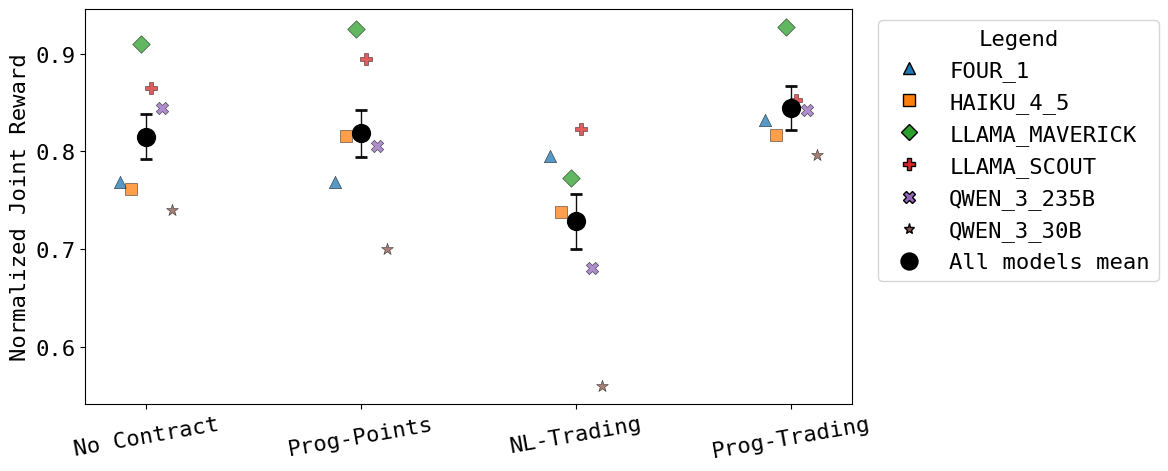

In [39]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

RT = df.copy()

bucket = ['Independent', 'Mutual Dependency', 'Asymmetric']
p4p = False
subset = RT[(RT['Bucket'].isin(bucket)) & (RT['Pay4Partner'] == p4p)].copy()

# Contract order
order = contract_order
subset['Contract Type'] = pd.Categorical(subset['Contract Type'], categories=order, ordered=True)

metric_col = "Normalized Joint Reward"

# Per-model means: ONE point per (Contract, Model)
model_means = (
    subset
    .groupby(['Contract Type', 'Model'], as_index=False, observed=True)[metric_col]
    .mean()
    .rename(columns={metric_col: 'Score'})
)

# Overall mean across models per contract + CI across datapoints
avg_stats = (
    subset
    .groupby(['Contract Type'], observed=True)
    .agg(
        mean_score=(metric_col, 'mean'),
        sd=(metric_col, 'std'),
        n=(metric_col, 'count'),
    )
    .reset_index()
)

avg_stats['sem'] = avg_stats['sd'] / np.sqrt(avg_stats['n'])
avg_stats['ci95'] = 1.96 * avg_stats['sem']
avg_stats.loc[avg_stats['n'] <= 1, 'ci95'] = 0.0
avg_stats = avg_stats.sort_values('Contract Type')

# Models + distinct shapes (NO circles reserved for means)
models = sorted(model_means['Model'].dropna().unique().tolist())
model_markers = ['^', 's', 'D', 'P', 'X', '*', 'v', '<', '>', 'H']
if len(models) > len(model_markers):
    raise ValueError(f"Not enough marker shapes for {len(models)} models; add more to model_markers.")

model_to_marker = {m: model_markers[i] for i, m in enumerate(models)}

# Color palette: one color per model
palette = sns.color_palette("tab10", n_colors=len(models))
model_to_color = {m: palette[i] for i, m in enumerate(models)}

mean_color = "black"

fig, ax = plt.subplots(figsize=(12, 5))

# Deterministic x positions
xpos = {ct: i for i, ct in enumerate(order)}

# Fixed offsets for models within each contract (evenly spaced)
span = 0.12
offsets = (
    [0.0] if len(models) == 1
    else list(np.linspace(-span, span, num=len(models)))
)
model_to_offset = {m: offsets[i] for i, m in enumerate(models)}

# --- Per-model points: deterministic offsets ---
for m in models:
    d = model_means[model_means['Model'] == m].copy()
    if d.empty:
        continue

    xs = d['Contract Type'].map(xpos).to_numpy() + model_to_offset[m]
    ys = d['Score'].to_numpy()

    ax.scatter(
        xs,
        ys,
        s=80,
        marker=model_to_marker[m],
        color=model_to_color[m],
        alpha=0.75,
        edgecolors='k',
        linewidths=0.4,
        zorder=2,
    )

# --- Means: big centered circles (no offset) with 95% CI ---
d = avg_stats.copy()
xs = d['Contract Type'].map(xpos).to_numpy()
ys = d['mean_score'].to_numpy()
yerr = np.nan_to_num(d['ci95'].to_numpy(), nan=0.0)

# Mean marker
ax.scatter(
    xs,
    ys,
    s=160,
    marker='o',
    color=mean_color,
    alpha=1.0,
    edgecolors='k',
    linewidths=1.2,
    zorder=6,
)

# Error bars
ax.errorbar(
    xs,
    ys,
    yerr=yerr,
    fmt='none',
    ecolor=mean_color,
    elinewidth=1.0,
    capsize=4,
    capthick=2.0,
    alpha=0.95,
    zorder=10,
)

# X axis ticks from numeric positions
ax.set_xticks(range(len(order)))
ax.set_xticklabels(order, rotation=10, fontsize=DEFAULT_FONT_SIZE)

ax.set_ylabel('Normalized Joint Reward', fontsize=DEFAULT_FONT_SIZE)


legend_handles = []

legend_handles += [
    Line2D(
        [0], [0],
        marker=model_to_marker[m],
        linestyle='None',
        markerfacecolor=model_to_color[m],
        markeredgecolor='k',
        markersize=8,
        label=m,
    )
    for m in models
]

legend_handles += [
    Line2D(
        [0], [0],
        marker='o',
        linestyle='None',
        color=mean_color,
        markerfacecolor=mean_color,
        markeredgecolor='k',
        markeredgewidth=1.2,
        markersize=12,
        label='All models mean',
    ),
]

ax.legend(
    handles=legend_handles,
    title='Legend',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=DEFAULT_FONT_SIZE,
    title_fontsize=DEFAULT_FONT_SIZE,
)

name = f'normalized_total_score_by_contract_for_{bucket}_boards'
output_path = f"{output_folder}/{name}.pdf"
plt.savefig(output_path, format="pdf", bbox_inches="tight")
print(f"Saved figure to {output_path}")

plt.tight_layout()
plt.show()

### Trade volume important?

Plotting metric: total_trade_volume


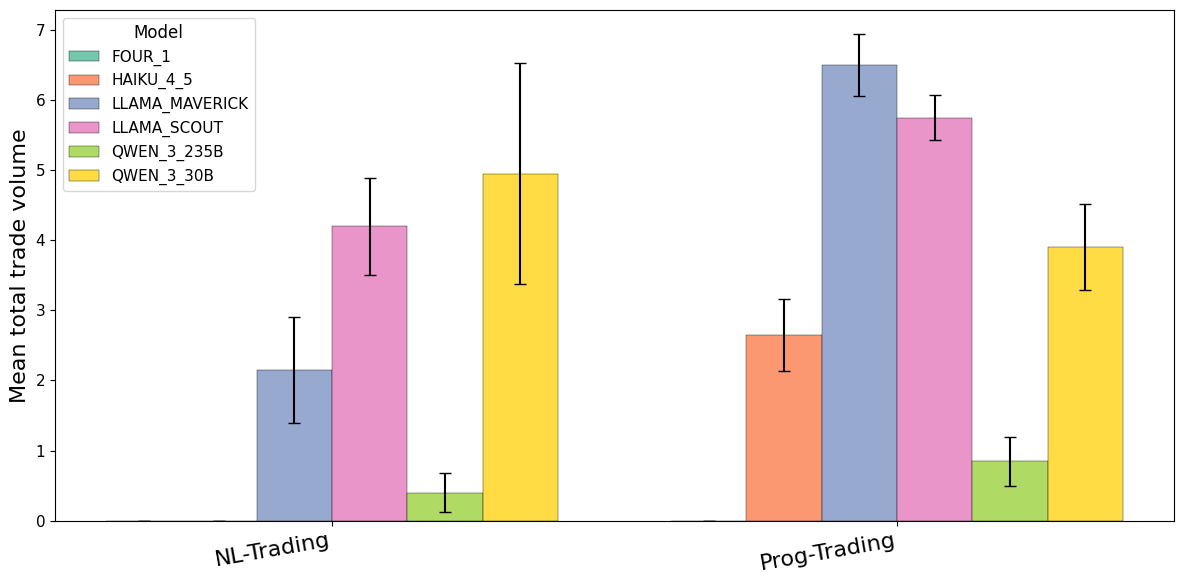

Plotting metric: moves_made_under_strict_contract_total


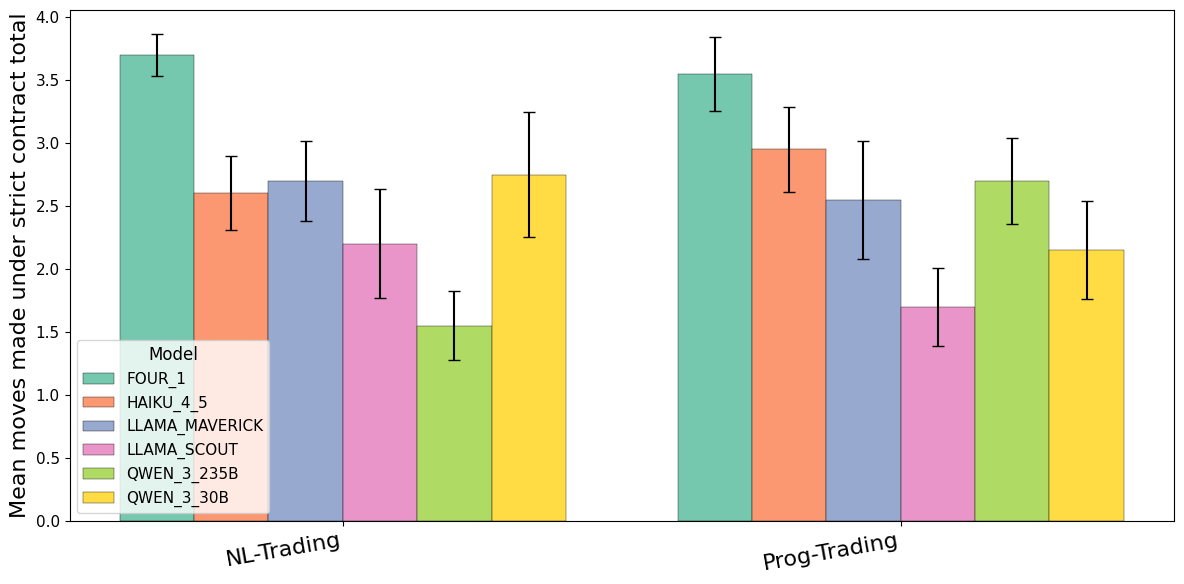

In [ ]:
core_metrics = [
{'df': df,
    'metric': 'total_trade_volume',
                 'x': 'Contract Type',
                 'hue': 'Model',
                 'order': None,
                 'hue_order': model_order,
                 'filters':[("Pay4Partner", [False]), 
                ('Contract Type', ['Prog-Trading', 'NL-Trading']),
                ('Bucket', ['Mutual Dependency'])],
},
{'df': df,
    'metric': 'moves_made_under_strict_contract_total',
                 'x': 'Contract Type',
                 'hue': 'Model',
                 'order': None,
                 'hue_order': model_order,
                 'filters':[("Pay4Partner", [False]), 
                ('Contract Type', ['Prog-Trading', 'NL-Trading']),
                ('Bucket', ['Mutual Dependency'])],
},
]

for metric_cfg in core_metrics:
    print(f"Plotting metric: {metric_cfg['metric']}")
    plot_mean_metric_bar(
        df=metric_cfg['df'],
        metric=metric_cfg['metric'],
        x=metric_cfg['x'],
        hue=metric_cfg.get('hue', None),
        filters=metric_cfg.get('filters', None),
        display_filter=metric_cfg.get('display_filter', True),
        order=metric_cfg.get('order', None),
        hue_order=metric_cfg.get('hue_order', None),
        ylim=None
        
    )

In [ ]:
df[(df['Bucket'] ==  'Mutual Dependency')
   & (df['Pay4Partner'] == False)
   
   ].groupby('Contract Type')[['Normalized Joint Reward','moves_made_under_strict_contract_total', 'Total Trades Proposed', 
                               'total_trade_acceptance_rate',
                               'total_trade_volume']].mean()

,Normalized Total Score,moves_made_under_strict_contract_total,Total Trades Proposed,total_trade_acceptance_rate,total_trade_volume
Contract Type,,,,,
Natural Language Tile,0.636310,2.583333,1.541667,0.403578,1.950000
No Contract,0.932440,0.000000,3.708333,0.632128,6.125000
Strict Finishing,0.955357,0.000000,3.258333,0.660374,6.058333
Strict Tile,0.864286,2.600000,2.825000,0.396096,3.275000


## Bad Trades

Model Pair LLAMA_MAVERICK-LLAMA_MAVERICK has 640 rows.
Model Pair QWEN_3_235B-QWEN_3_235B has 640 rows.
Model Pair QWEN_3_30B-QWEN_3_30B has 640 rows.
Model Pair LLAMA_SCOUT-LLAMA_SCOUT has 640 rows.
Model Pair FOUR_1-FOUR_1 has 640 rows.
Model Pair HAIKU_4_5-HAIKU_4_5 has 640 rows.
Formatted data with 6 unique model pairs,  3840 total rows
Plotting metric: Bad Trade


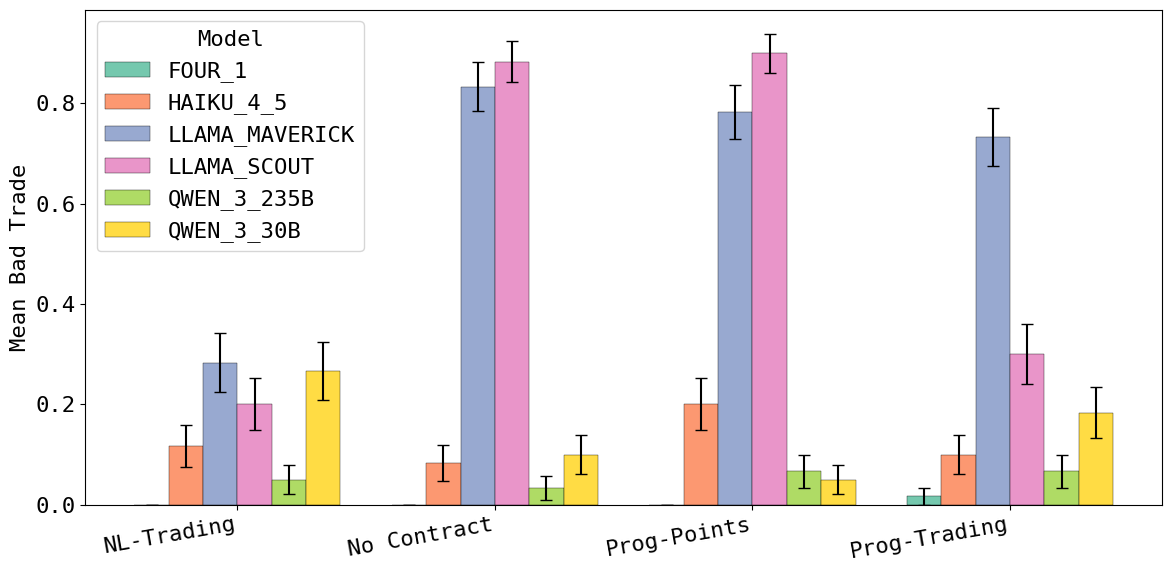

In [38]:
df = format_data(full_df)
core_metrics = [
{'df': df,
    'metric': 'Bad Trade',
                 'x': 'Contract Type',
                 'hue': 'Model',
                 'order': None,
                 'hue_order': model_order,
                 'filters':[("Pay4Partner", [False]), 
                # ('Contract Type', ['Strict Tile', 'Natural Language Tile']),
                ('Bucket', ['Independent', 'Mutually Dependent', 'Asymmetric'])],
},
]

for metric_cfg in core_metrics:
    print(f"Plotting metric: {metric_cfg['metric']}")
    plot_mean_metric_bar(
        df=metric_cfg['df'],
        metric=metric_cfg['metric'],
        x=metric_cfg['x'],
        hue=metric_cfg.get('hue', None),
        filters=metric_cfg.get('filters', None),
        display_filter=metric_cfg.get('display_filter', True),
        order=metric_cfg.get('order', None),
        hue_order=metric_cfg.get('hue_order', None),
        ylim=None
        
    )

## Summary Tables

### Summary fn

In [34]:

import numpy as np
import pandas as pd

def print_model_metric_summaries(
    df: pd.DataFrame,
    metrics: list[str],
    p4p: list[bool] | None = None,
    contract_types: list[str] | None = None,
    buckets: list[str] | None = None,
    model_col: str = "Model",
):
    """
    For each model, print mean ± SEM for each metric in `metrics`,
    optionally filtered by Pay4Partner, Contract Type, and Bucket.
    """

    data = df.copy()

    # Apply filters
    if p4p is not None:
        data = data[data["Pay4Partner"].isin(p4p)]
    if contract_types is not None:
        data = data[data["Contract Type"].isin(contract_types)]
    if buckets is not None:
        data = data[data["Bucket"].isin(buckets)]

    # Drop rows missing any of the required columns
    required = [model_col] + metrics
    missing = [c for c in required if c not in data.columns]
    if missing:
        raise ValueError(f"Missing required columns in df: {missing}")

    data = data.dropna(subset=required)
    if data.empty:
        print("No data left after filtering.")
        return

    # Group by model and compute mean / sem for each metric
    grouped = (
        data
        .groupby(model_col)[metrics]
        .agg(["mean", "std", "count"])
    )

    # Flatten MultiIndex columns: (metric, stat) -> metric_stat
    grouped.columns = [f"{m}_{s}" for m, s in grouped.columns]
    grouped = grouped.reset_index()

    # Human-readable filter description
    filter_parts = []
    if p4p is not None:
        filter_parts.append(f"Pay4Partner in {p4p}")
    if contract_types is not None:
        filter_parts.append(f"Contract Type in {contract_types}")
    if buckets is not None:
        filter_parts.append(f"Bucket in {buckets}")
    filter_text = " | ".join(filter_parts) if filter_parts else "No filters"

    print(f"Model metric summaries ({filter_text})")
    print("-" * 80)

    z = 1.96  # 95% normal approximation

    for _, row in grouped.iterrows():
        model_name = row[model_col]
        print(f"Model: {model_name}")
        for metric in metrics:
            mean_val = row.get(f"{metric}_mean", np.nan)
            std_val = row.get(f"{metric}_std", np.nan)
            n_val = row.get(f"{metric}_count", 0)

            if n_val and n_val > 1 and pd.notna(std_val):
                sem_val = std_val / np.sqrt(n_val)
                ci_half_width = z * sem_val
            else:
                ci_half_width = 0.0

            print(f"  {metric}: {mean_val:.3f} ± {ci_half_width:.3f}")
        print("-" * 80)



### Results

In [ ]:
# Example usage:
print_model_metric_summaries(
    df,
    metrics=['Score P-Red',
             'Score P-Blue',
             'Normalized Joint Reward',
             'Proportion of Total Points for P-Red',
            ],
    p4p=[False],
    contract_types=["No Contract"],
    # buckets=["Mutual Dependency"],
)


Model metric summaries (Pay4Partner in [False] | Contract Type in ['No Contract'])
--------------------------------------------------------------------------------
Model: FOUR_1
  Score Player 0: 69.000 ± 0.806
  Score Player 1: 38.625 ± 7.939
  Normalized Total Score: 0.769 ± 0.055
  Proportion of Total Points for P-Red: 0.724 ± 0.057
--------------------------------------------------------------------------------
Model: HAIKU_4_5
  Score Player 0: 69.625 ± 1.784
  Score Player 1: 37.000 ± 7.592
  Normalized Total Score: 0.762 ± 0.055
  Proportion of Total Points for P-Red: 0.729 ± 0.057
--------------------------------------------------------------------------------
Model: LLAMA_MAVERICK
  Score Player 0: 70.696 ± 2.160
  Score Player 1: 58.354 ± 5.331
  Normalized Total Score: 0.922 ± 0.041
  Proportion of Total Points for P-Red: 0.576 ± 0.041
--------------------------------------------------------------------------------
Model: LLAMA_SCOUT
  Score Player 0: 65.921 ± 3.231
  Score 

In [ ]:
# BBB for Asymmetric
print_model_metric_summaries(
    df,
    metrics=['Both Players Beat Baseline',
            ],
    p4p=[False],
    contract_types=["No Contract"],
    buckets=["Asymmetric"],
)


Model metric summaries (Pay4Partner in [False] | Contract Type in ['No Contract'] | Bucket in ['Asymmetric'])
--------------------------------------------------------------------------------
Model: FOUR_1
  Both Players Beat Baseline: 0.075 ± 0.083
--------------------------------------------------------------------------------
Model: HAIKU_4_5
  Both Players Beat Baseline: 0.100 ± 0.094
--------------------------------------------------------------------------------
Model: LLAMA_MAVERICK
  Both Players Beat Baseline: 0.425 ± 0.155
--------------------------------------------------------------------------------
Model: LLAMA_SCOUT
  Both Players Beat Baseline: 0.150 ± 0.112
--------------------------------------------------------------------------------
Model: QWEN_3_235B
  Both Players Beat Baseline: 0.400 ± 0.154
--------------------------------------------------------------------------------
Model: QWEN_3_30B
  Both Players Beat Baseline: 0.075 ± 0.083
-------------------------------

In [ ]:

import numpy as np
import pandas as pd

def print_overall_metric_summaries(
    df: pd.DataFrame,
    metrics: list[str],
    p4p: list[bool] | None = None,
    contract_types: list[str] | None = None,
    buckets: list[str] | None = None,
):
    """
    Print overall mean ± 95% CI for each metric in `metrics`,
    optionally filtered by Pay4Partner, Contract Type, and Bucket.
    CI is mean ± 1.96 * SEM (normal approximation).
    """
    data = df.copy()

    # Apply filters
    if p4p is not None:
        data = data[data["Pay4Partner"].isin(p4p)]
    if contract_types is not None:
        data = data[data["Contract Type"].isin(contract_types)]
    if buckets is not None:
        data = data[data["Bucket"].isin(buckets)]

    # Drop rows missing any of the required columns
    required = metrics
    missing = [c for c in required if c not in data.columns]
    if missing:
        raise ValueError(f"Missing required columns in df: {missing}")

    data = data.dropna(subset=required)
    if data.empty:
        print("No data left after filtering.")
        return

    # Human-readable filter description
    filter_parts = []
    if p4p is not None:
        filter_parts.append(f"Pay4Partner in {p4p}")
    if contract_types is not None:
        filter_parts.append(f"Contract Type in {contract_types}")
    if buckets is not None:
        filter_parts.append(f"Bucket in {buckets}")
    filter_text = " | ".join(filter_parts) if filter_parts else "No filters"

    print(f"OVERALL metric summaries (mean ± 95% CI) [{filter_text}]")
    print("-" * 80)

    z = 1.96  # 95% normal approximation

    for metric in metrics:
        vals = data[metric].to_numpy()
        n = np.isfinite(vals).sum()
        mean_val = np.nanmean(vals)
        std_val = np.nanstd(vals, ddof=1) if n > 1 else 0.0

        if n > 1 and std_val > 0:
            sem_val = std_val / np.sqrt(n)
            ci_half_width = z * sem_val
        else:
            ci_half_width = 0.0

        print(f"{metric}: {mean_val:.3f} ± {ci_half_width:.3f} (n={n})")
    print("-" * 80)

In [ ]:
print_overall_metric_summaries(
    df,
    metrics=['Score P-Red',
             'Score Player 1',
             'Normalized Joint Reward',
             'Proportion of Total Points for P-Red',
            ],
    p4p=[False],
    contract_types=["No Contract"],
    # buckets=["Mutual Dependency"],
)

# BBB for Asymmetric
print_overall_metric_summaries(
    df,
    metrics=['Both Players Beat Baseline',
            ],
    p4p=[False],
    contract_types=["No Contract"],
    buckets=["Asymmetric"],
)


OVERALL metric summaries (mean ± 95% CI) [Pay4Partner in [False] | Contract Type in ['No Contract']]
--------------------------------------------------------------------------------
Score Player 0: 68.787 ± 0.951 (n=470)
Score Player 1: 47.734 ± 3.004 (n=470)
Normalized Total Score: 0.832 ± 0.021 (n=470)
Proportion of Total Points for P-Red: 0.651 ± 0.023 (n=470)
--------------------------------------------------------------------------------
OVERALL metric summaries (mean ± 95% CI) [Pay4Partner in [False] | Contract Type in ['No Contract'] | Bucket in ['Asymmetric']]
--------------------------------------------------------------------------------
Both Players Beat Baseline: 0.204 ± 0.051 (n=240)
--------------------------------------------------------------------------------


## Symmetry level and failure

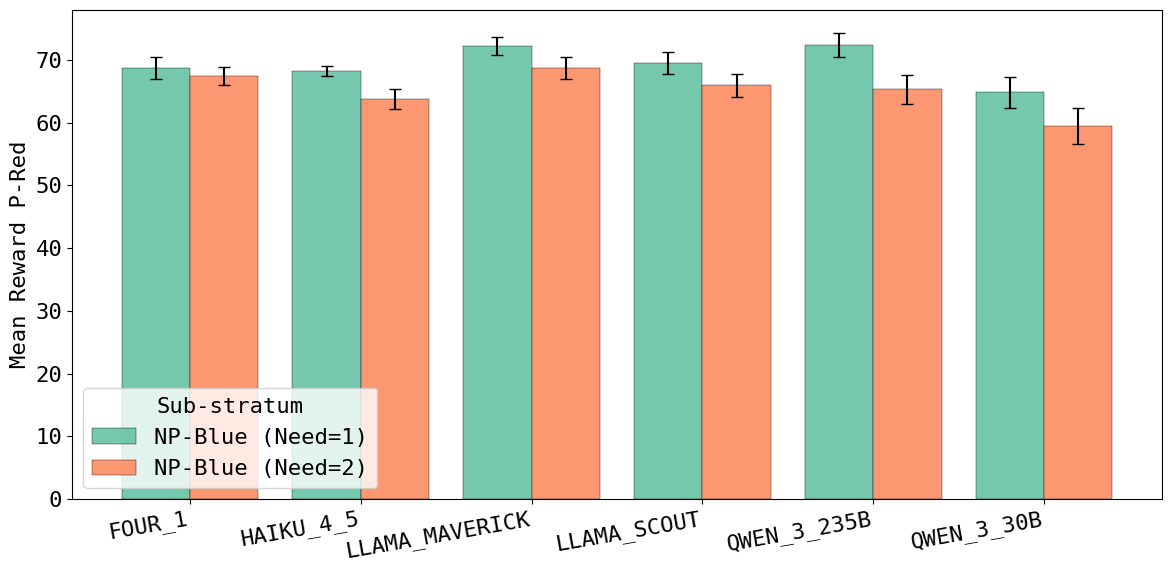

,Model,Sub-stratum,mean,std,n,sem
0,FOUR_1,NP-Blue (Need=1),68.6750,15.351390,80,1.716338
1,FOUR_1,NP-Blue (Need=2),67.4625,12.824960,80,1.433874
2,HAIKU_4_5,NP-Blue (Need=1),68.2250,6.959148,80,0.778056
3,HAIKU_4_5,NP-Blue (Need=2),63.7250,14.409012,80,1.610976
4,LLAMA_MAVERICK,NP-Blue (Need=1),72.1875,12.426079,80,1.389278
5,LLAMA_MAVERICK,NP-Blue (Need=2),68.7125,15.213413,80,1.700911
6,LLAMA_SCOUT,NP-Blue (Need=1),69.5500,15.638236,80,1.748408
7,LLAMA_SCOUT,NP-Blue (Need=2),65.9500,16.249557,80,1.816756
8,QWEN_3_235B,NP-Blue (Need=1),72.3125,17.166050,80,1.919223
9,QWEN_3_235B,NP-Blue (Need=2),65.3000,20.285556,80,2.267994


In [ ]:
plot_mean_metric_bar(
    df=df,
    metric='Reward P-Red',
    x='Model',
    hue='Sub-stratum',
    filters=[
        ('Bucket', ['Asymmetric']), 
        ("Pay4Partner", [False]), 
        ],
    ylim=None
    # title="Proportion of Runs Where Both Players Beat Baseline (Independent Bucket)",
    # rotate_xticks=0,
    # ylim=(0, 1),
)

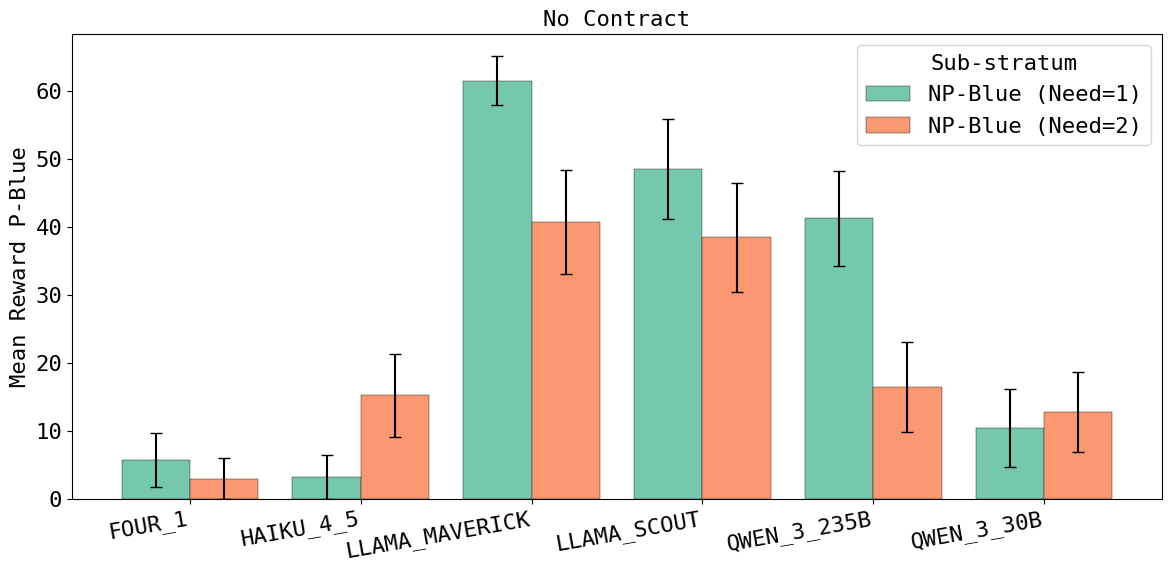

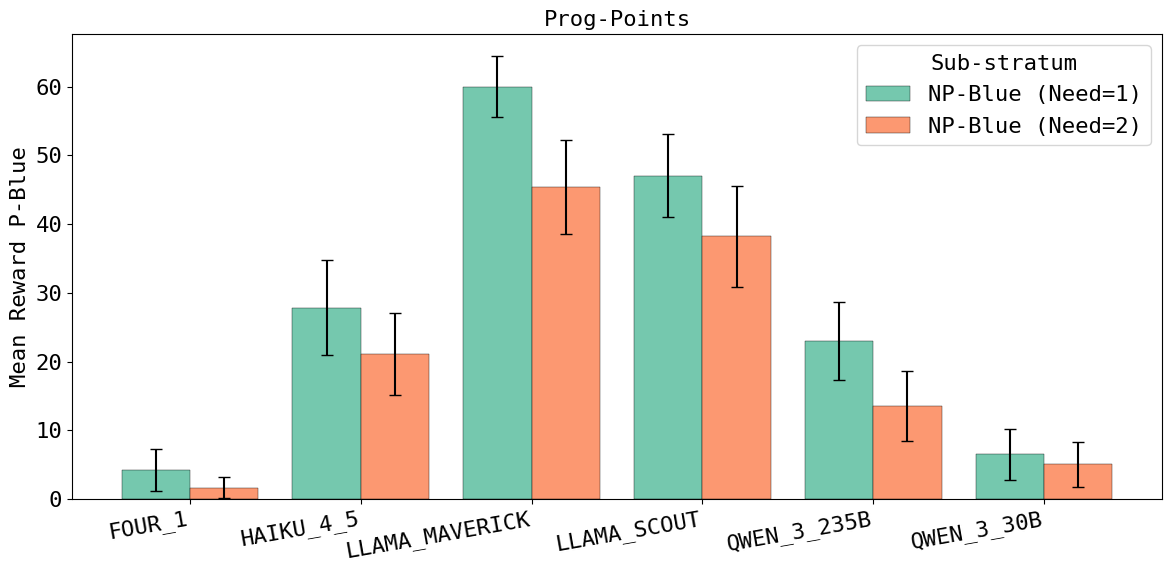

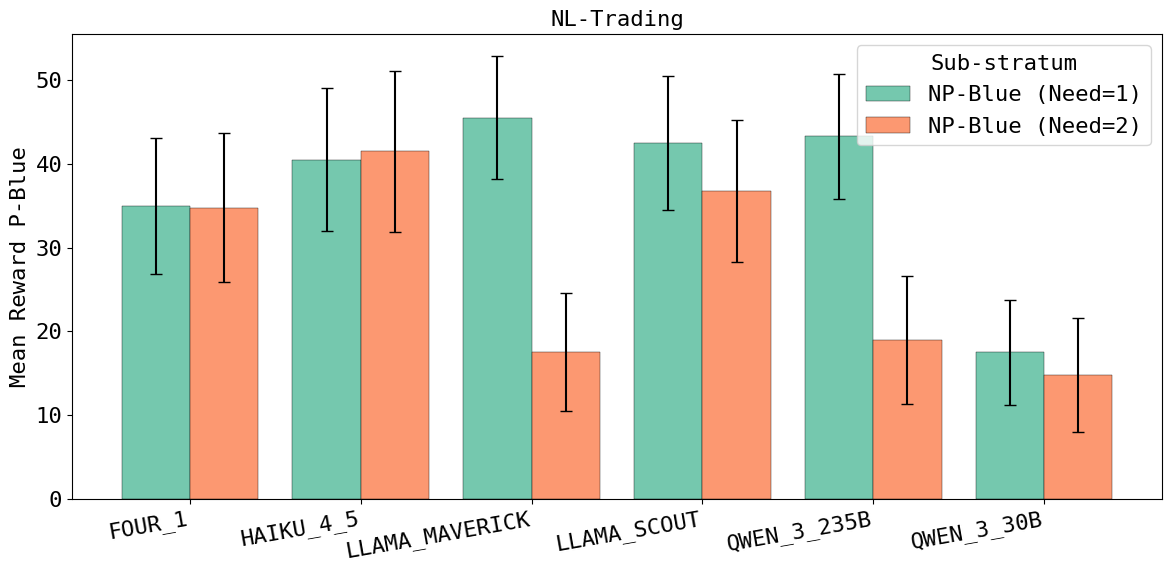

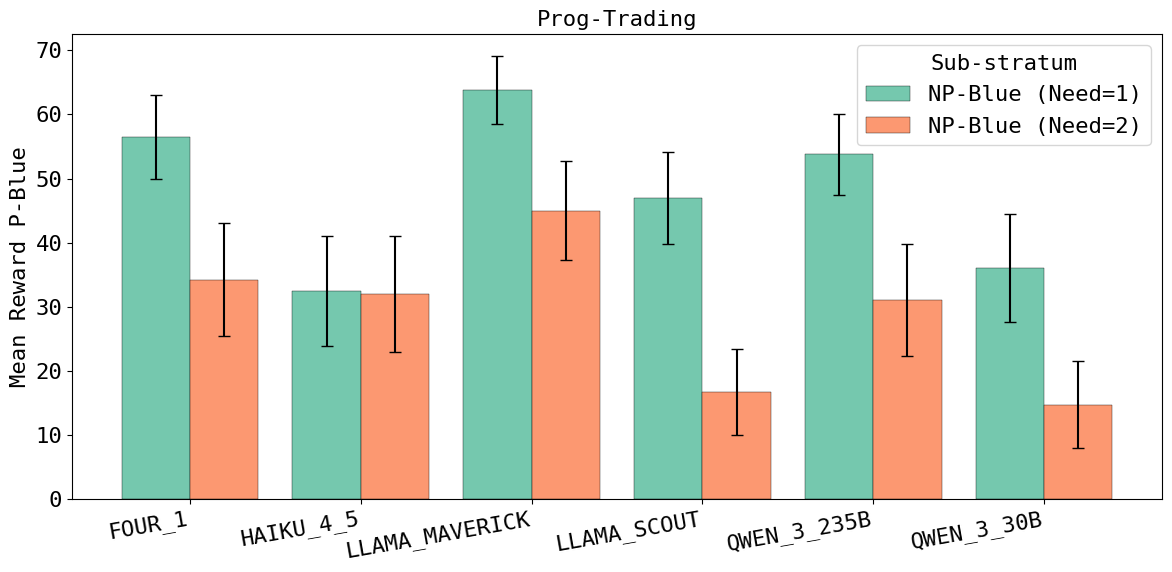

In [ ]:
for contract in contract_order:
    plot_mean_metric_bar(
    df=df,
    metric='Reward P-Blue',
    x='Model',
    hue='Sub-stratum',
    filters=[
        ('Bucket', ['Asymmetric']), 
        ("Pay4Partner", [False]), 
        ("Contract Type", [contract])
        ],
    title=contract,
    ylim=None
    
)

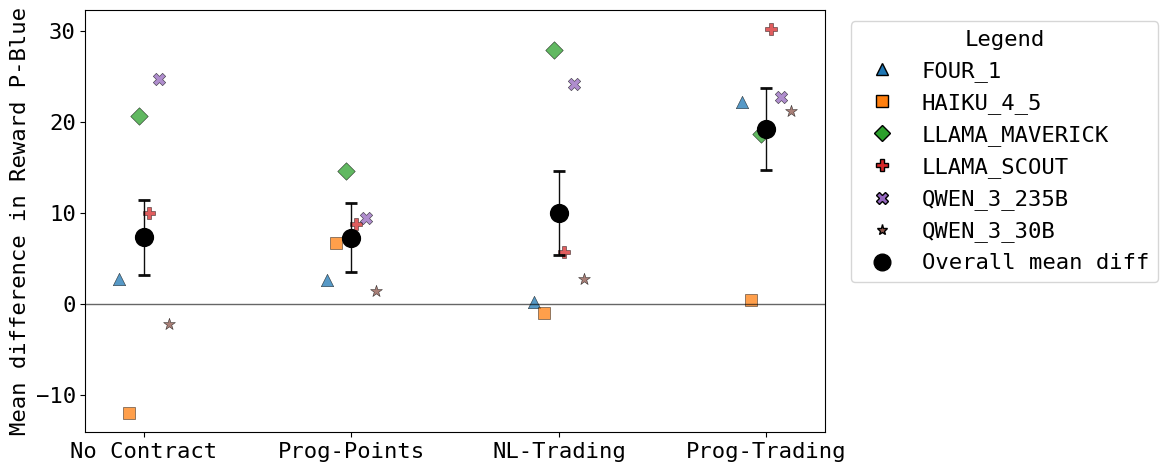

Sub-stratum,Contract Type,Model,NP-Blue (Need=1),NP-Blue (Need=2),diff
0,No Contract,FOUR_1,5.75,3.00,2.75
1,No Contract,HAIKU_4_5,3.25,15.25,-12.00
2,No Contract,LLAMA_MAVERICK,61.50,40.75,20.75
3,No Contract,LLAMA_SCOUT,48.50,38.50,10.00
4,No Contract,QWEN_3_235B,41.25,16.50,24.75


,Contract Type,mean_diff,se_diff,n1,n2
0,No Contract,7.333333,4.147262,120,120
1,Prog-Points,7.291667,3.805308,120,120
2,NL-Trading,10.000000,4.645683,120,120
3,Prog-Trading,19.291667,4.508996,120,120


In [ ]:

from matplotlib.lines import Line2D

def plot_blue_reward_need_diff_by_contract_scatter(
    df: pd.DataFrame,
    bucket: str = "Asymmetric",
    p4p: bool = False,
    contract_order: list[str] | None = None,
    sub1: str = "NP-Blue (Need=1)",
    sub2: str = "NP-Blue (Need=2)",
    metric: str = "Reward P-Blue",
    reverse: bool = True,  # if True: (sub1 - sub2). If False: (sub2 - sub1)
    figsize=(12, 5),
    rotate_xticks=0,
    title: str | None = '',
    span: float = 0.12,     # horizontal spread for model points (like your cell-70 style)
):
    """
    Scatter-style plot per contract:
      - one point per model = (mean(metric | sub1, model) - mean(metric | sub2, model)) by default (reverse=True)
      - big mean point (across all rows) with SE_diff error bar:
            SE_diff = sqrt(SD1^2/n1 + SD2^2/n2)

    Notes:
      - "model points" use per-model sub-stratum means, then take the difference (paired by model).
      - "mean + error bar" uses the unpaired formula you provided (SD1^2/n1 + SD2^2/n2).
    """
    data = df.copy()
    data = data[
        (data["Bucket"] == bucket) &
        (data["Pay4Partner"] == p4p) &
        (data["Sub-stratum"].isin([sub1, sub2]))
    ].copy()

    required = ["Contract Type", "Model", "Sub-stratum", metric]
    missing = [c for c in required if c not in data.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")

    # Ensure contract order
    if contract_order is None:
        contract_order = sorted(data["Contract Type"].dropna().unique().tolist())
    data["Contract Type"] = pd.Categorical(data["Contract Type"], categories=contract_order, ordered=True)

    # --------------------------
    # Per-model differences (one point per model per contract)
    # --------------------------
    model_stats = (
        data
        .groupby(["Contract Type", "Model", "Sub-stratum"], observed=True)[metric]
        .mean()
        .reset_index(name="mean_metric")
    )

    wide = model_stats.pivot_table(
        index=["Contract Type", "Model"],
        columns="Sub-stratum",
        values="mean_metric",
        observed=True,
    )

    # drop model/contract pairs missing either sub-stratum
    wide = wide.dropna(subset=[sub1, sub2]).reset_index()

    if reverse:
        wide["diff"] = wide[sub1] - wide[sub2]
        diff_label = f"{sub1} − {sub2}"
    else:
        wide["diff"] = wide[sub2] - wide[sub1]
        diff_label = f"{sub2} − {sub1}"

    # --------------------------
    # Overall mean difference + SE_diff (your formula, unpaired)
    # --------------------------
    stats = (
        data
        .groupby(["Contract Type", "Sub-stratum"], observed=True)[metric]
        .agg(mean="mean", sd="std", n="count")
        .reset_index()
    )
    mean_w = stats.pivot(index="Contract Type", columns="Sub-stratum", values="mean")
    sd_w   = stats.pivot(index="Contract Type", columns="Sub-stratum", values="sd")
    n_w    = stats.pivot(index="Contract Type", columns="Sub-stratum", values="n")

    mean_w = mean_w.reindex(contract_order)
    sd_w   = sd_w.reindex(contract_order)
    n_w    = n_w.reindex(contract_order)

    if reverse:
        mean_diff = mean_w[sub1] - mean_w[sub2]
    else:
        mean_diff = mean_w[sub2] - mean_w[sub1]

    se_diff = np.sqrt((sd_w[sub1] ** 2) / n_w[sub1] + (sd_w[sub2] ** 2) / n_w[sub2])
    se_diff = se_diff.fillna(0.0)

    summary = pd.DataFrame({
        "Contract Type": contract_order,
        "mean_diff": mean_diff.to_numpy(),
        "se_diff": se_diff.to_numpy(),
        "n1": n_w[sub1].to_numpy(),
        "n2": n_w[sub2].to_numpy(),
    })

    # --------------------------
    # Plot (cell-70 style scatter)
    # --------------------------
    fig, ax = plt.subplots(figsize=figsize)

    xpos = {ct: i for i, ct in enumerate(contract_order)}

    # Model styling: shape+color by model (like your other scatter)
    models = sorted(wide["Model"].dropna().unique().tolist())
    model_markers = ['^', 's', 'D', 'P', 'X', '*', 'v', '<', '>', 'H']
    if len(models) > len(model_markers):
        raise ValueError(f"Not enough marker shapes for {len(models)} models; add more to model_markers.")
    model_to_marker = {m: model_markers[i] for i, m in enumerate(models)}

    palette = sns.color_palette("tab10", n_colors=len(models))
    model_to_color = {m: palette[i] for i, m in enumerate(models)}

    # deterministic offsets by model within each contract
    offsets = [0.0] if len(models) == 1 else list(np.linspace(-span, span, num=len(models)))
    model_to_offset = {m: offsets[i] for i, m in enumerate(models)}

    # Per-model points
    for m in models:
        dm = wide[wide["Model"] == m].copy()
        if dm.empty:
            continue
        xs = dm["Contract Type"].map(xpos).to_numpy() + model_to_offset[m]
        ys = dm["diff"].to_numpy()

        ax.scatter(
            xs,
            ys,
            s=80,
            marker=model_to_marker[m],
            color=model_to_color[m],
            alpha=0.75,
            edgecolors="k",
            linewidths=0.4,
            zorder=2,
        )

    # Mean point + error bar at center
    mean_color = "black"
    xs_m = np.arange(len(contract_order))
    ys_m = summary["mean_diff"].to_numpy(dtype=float)
    yerr = summary["se_diff"].to_numpy(dtype=float)

    ax.scatter(
        xs_m,
        ys_m,
        s=160,
        marker="o",
        color=mean_color,
        alpha=1.0,
        edgecolors="k",
        linewidths=1.2,
        zorder=6,
        label="Overall mean diff",
    )
    ax.errorbar(
        xs_m,
        ys_m,
        yerr=yerr,
        fmt="none",
        ecolor=mean_color,
        elinewidth=1.0,
        capsize=4,
        capthick=2.0,
        alpha=0.95,
        zorder=10,
    )

    ax.axhline(0.0, color="black", linewidth=1, alpha=0.6)

    ax.set_xticks(range(len(contract_order)))
    ax.set_xticklabels(contract_order, rotation=rotate_xticks, ha="center",fontsize=DEFAULT_FONT_SIZE)
    ax.set_ylabel(f"Mean difference in {metric}", fontsize=DEFAULT_FONT_SIZE)

    if title is None:
        title = f"{metric} difference by contract ({bucket}, Pay4Partner={p4p})"
    ax.set_title(title, fontsize=DEFAULT_FONT_SIZE)

    # Legend: models + mean point
    legend_handles = [
        Line2D([0], [0], marker=model_to_marker[m], linestyle="None",
               markerfacecolor=model_to_color[m], markeredgecolor="k",
               markersize=8, label=m)
        for m in models
    ] + [
        Line2D([0], [0], marker="o", linestyle="None",
               markerfacecolor=mean_color, markeredgecolor="k",
               color=mean_color, markersize=12, label="Overall mean diff"),
    ]

    ax.legend(
        handles=legend_handles,
        title="Legend",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        fontsize=DEFAULT_FONT_SIZE,
        title_fontsize=DEFAULT_FONT_SIZE,
    )

    plt.tight_layout()
    plt.show()

    return wide, summary


# Example:
model_level_diffs, overall_summary = plot_blue_reward_need_diff_by_contract_scatter(
    df=df,
    bucket="Asymmetric",
    p4p=False,
    contract_order=contract_order,
    metric="Reward P-Blue",
    sub1="NP-Blue (Need=1)",
    sub2="NP-Blue (Need=2)",
    reverse=True,  # reverse direction: Need=1 minus Need=2
)
display(model_level_diffs.head())
display(overall_summary)
